![](https://i.imgur.com/WrndCh8.png)

# 1. Introduction
Injuries are a big problem in many sports, from football to wrestling. An injury could retire an athlete from weeks until an entire season, or even in the worst cases end a carreer. Given this scenario, it's important to guarantee the safe of athlete, recognizing patterns could be their body health in risk. The NFL has some notoriuos cases of serious injuries like [Tom Brady knee injury](http://www.nfl.com/news/story/09000d5d80a95089/article/brady-to-have-seasonending-knee-surgery-will-be-placed-on-ir) in 2008, what made Brady retires for all the rest of the Season, to take another sports as example and the danger of injuries, there's the case of [Paige's accidental kick](https://wrestletalk.com/news/nothing-was-ever-sashas-fault-paige-opens-up-about-career-ending-neck-injury/) delivered by Sasha Banks on WWE, this ended Paige's carreer.<br>
<br>
In this work, I analyze the data of [NFL 1st and Future - Analytics](https://www.kaggle.com/c/nfl-playing-surface-analytics/data) competition to find patterns that could lead to an injury on a NFL match and aid to find ways to give a better condition to every player make your best without so many high risks, we want less injury and more touchdowns!<br>
<br>
The data exploration is made with interactive plots, you can hover the mouse on it to see the values, and explanations for every insight from the plots. I will focus in every type of injury and how they interact with the different surfaces and some other features.<br>
<br>
You can click on the buttons to see any hidden cells or outputs, and see which modules and the helper functions that I use in this kernel. I made this to have a clean visualization of the analysis.

In [1]:
# Modules
# Core
import numpy as np
import pandas as pd
# Visualizations
import matplotlib.pylab as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style("darkgrid")
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
from plotly.subplots import make_subplots
import plotly.graph_objs as go
init_notebook_mode(connected=True)
# Tools
from IPython.display import HTML, display
import os
import io
import pprint
import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = "retina"

DATA_PATH = '../input/nfl-playing-surface-analytics/'

print(os.listdir(DATA_PATH))

['InjuryRecord.csv', 'PlayerTrackData.csv', 'PlayList.csv']


In [2]:
# Helper Functions
# For reduce dataframe memory size, there's a big dataframe here
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    return df

# Import data and reduce RAM usage
def import_data(file):
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

# Get dataframe info like columns, missing values, data type, etc.
def get_df_info(df):
    display(df.head(3).style.hide_index().
            set_properties(**{'text-align': 'center'}))
    buf = io.StringIO()
    df.info(buf=buf)
    info = buf.getvalue().split('\n')[-2]
    df_samples = pd.DataFrame({'Number of Samples': df.shape[0], 
                               'Number of Features' : df.shape[1]},
                             index=[0])
    display(df_samples.style.hide_index()
            .set_properties(**{'text-align': 'center'}))
    df_types = df.dtypes
    df_types = pd.DataFrame({'Column':df_types.index, 'Type':df_types.values})
    display(df_types.style.hide_index()
            .set_properties(**{'text-align': 'center'})) 
    missing = df.isnull().sum().sort_values(ascending=False)
    if missing.values.sum() == 0:
        missing = pd.DataFrame({'Missing Values' : "No Missing Values"})
    else:
        missing = missing[missing > 0]
        missing = pd.DataFrame({'Feature' : missing.index, 'Missing Values' : missing.values})
        display(missing.style.hide_index()
                .set_properties(**{'text-align': 'center'}))
  

# Plot the Football Field.
# Source: https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

# 2. Data Information
# 2.1 Basic Data Info
The Dataset contains 3 files in csv format, and they are:<br>
<br>
* **Injury Record:** The injury record file in .csv format contains information on 105 lower-limb injuries that occurred during regular season games over the two seasons. Injuries can be linked to specific records in a player history using the PlayerKey, GameID, and PlayKey fields.

* **Play List:** The play list file contains the details for the 267,005 player-plays that make up the dataset. Each play is indexed by PlayerKey, GameID, and PlayKey fields. Details about the game and play include the player’s assigned roster position, stadium type, field type, weather, play type, position for the play, and position group.

* **Player Track Data:** Player level data that describes the location, orientation, speed, and direction of each player during a play recorded at 10 Hz (i.e. 10 observations recorded per second).
<br>

Every file is mapped in a variable, where every variable is a dataframe as shown in the Table 1.

**Table 1 - Data File mapped Variables**
   
|File   |Variable |
|---|---|
| Injury Record  | `injury_record`|
|  Play List | `play_list`|
|  Player Track Data | `player_track`|<br>

All the data was collected by [NFL Next Gen Stats](https://nextgenstats.nfl.com/), this system collects player information (location, speed) in match in real time, granting the possibility to make big data analysis. The dataset collects information of 250 Players, as described on the [data information for this competition](https://www.kaggle.com/c/nfl-playing-surface-analytics/data) for two seasons.<br> Every dataset by connected by keys as shown on Table 2, it is useful to take note because will be helpful to make dataframe joins.

**Table 2 - Data File Keys**

|File|PlayerKey|GameID|Playkey|
|---|---|---|---|
| Injury Record  | yes| yes |yes |
|  Play List | yes| yes |yes |
|  Player Track Data | no| no |yes |

Let's load the data and see information about every file, like number of columns, samples, data type and missing values. And for now on, every file is treated as it variable name. Columns in dataframes will be called features and rows as samples.

In [3]:
injury_record = import_data(DATA_PATH+"InjuryRecord.csv")
play_list = import_data(DATA_PATH+"PlayList.csv")
player_track = pd.read_csv(DATA_PATH+"PlayerTrackData.csv")

In [4]:
print('injury_record Data Information')
get_df_info(injury_record)
print('play_list Data Information')
get_df_info(play_list)
print('player_track Data Information')
get_df_info(player_track)

injury_record Data Information


PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1


Number of Samples,Number of Features
105,9


Column,Type
PlayerKey,int32
GameID,category
PlayKey,category
BodyPart,category
Surface,category
DM_M1,int8
DM_M7,int8
DM_M28,int8
DM_M42,int8


Feature,Missing Values
PlayKey,28


play_list Data Information


PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB
26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB
26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB


Number of Samples,Number of Features
267005,14


Column,Type
PlayerKey,int32
GameID,category
PlayKey,category
RosterPosition,category
PlayerDay,int16
PlayerGame,int8
StadiumType,category
FieldType,category
Temperature,int16
Weather,category


Feature,Missing Values
Weather,18691
StadiumType,16910
PlayType,367


player_track Data Information


PlayKey,time,event,x,y,dir,dis,o,s
26624-1-1,0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13
26624-1-1,0.1,nan,87.45,28.92,283.91,0.01,261.69,0.12
26624-1-1,0.2,nan,87.44,28.92,280.4,0.01,261.17,0.12


Number of Samples,Number of Features
76366748,9


Column,Type
PlayKey,object
time,float64
event,object
x,float64
y,float64
dir,float64
dis,float64
o,float64
s,float64


Feature,Missing Values
event,74526875
o,2
dir,2


Some important notes to take about these dataframes:
* `injury_record` has 28 missing values, it represents almost 30% of the total values, the dataframe has 105 samples, is tiny. It's an important feature to use to make de Explanatory Data Analysis (EDA). A good way is reconstruct the `PlayKey`.
* `injury_record` has features one-hot encoded (DM_M1 to DM_42), which represent the amount of days that the Player is out of the Season, to make easy the EDA, this feature will return to the original values as integer type.
* `play_list` has a good amount of samples (267005) and features (14) and it will provide so much valuable information to get insights and how the injuries ocurred. The missing values could be bypassed with Feature Engineering or dropped if so tiny in relation of the dataframe total size.
* `player_track` has a huge amount of samples (76366748) and 9 features and it provides the coordinates, speed and time of plays. On the missing values it has a tiny amount in `o` and `dir`, it could be dropped, but `event` has a extreme large amount (74526875), it's good investigate the values when make the EDA.

Time to deal with the issues on the dataframes, let's start understanding how `PlayKey` is build and try to reconstruct it. <br>
Let's clean the data and proceed with the analysis.

In [5]:
# Clean Data
# StadiumType corrections
stadium_dict = {"Oudoor" : "Outdoor", "Outdoors" : "Outdoor", "Outdor" : "Outdoor", "Ourdoor" : "Outdoor", 
                "Outdoor Retr Roof-Open" : "Outdoor", "Open" : "Outdoor", 'Outdoor Retr Roof-Open' : "Outdoor",
                "Outddors" : "Outdoor", 'Retr. Roof-Open' : "Outdoor",  "Indoor, Open Roof" : "Outdoor", "Heinz Field" : "Outdoor",
                 "Domed, Open" : "Outdoor", "Domed, open" : "Outdoor", 'Retr. Roof - Open' : "Outdoor", "Outside" : "Outdoor",
                "Closed Dome" : "Indoor", "Domed, closed" : "Indoor", "Dome" : "Indoor", "Domed" : "Indoor", 
                "Indoors" : "Indoor", 'Retr. Roof-Closed' : "Indoor", "Retractable Roof" : "Indoor",  'Indoor, Roof Closed' : "Indoor",
                "Retr. Roof - Closed" : "Indoor", 'Dome, closed' : "Indoor", "Retr. Roof Closed" : "Indoor", "nan" : np.NaN, 'Cloudy' : np.NaN}

# Weather corrections
weather_dict = {"Indoors" : "Indoor", "N/A (Indoors)": "Indoor", "Clear skies" : "Clear", "Clear Skies" : "Clear",
                "Clear and cold" : "Clear", 'Cloudy, light snow accumulating 1-3"' : "Cloudy",
                "Rain shower" : "Rain", "Cloudy, 50% change of rain" : "Cloudy", "Clear and warm" : "Clear", 
                "Cloudy with periods of rain" : "Cloudy", "Light Rain" : "Rain", "Light rain" : "Rain", 'Rain Chance 40%' : "Cloudy",
                "Mostly sunny" : "Sunny", "Mostly Sunny" : "Sunny", "Sun & clouds" : "Sunny", "Partly Cloudy" : "Cloudy",
                "Partly cloudy" : "Cloudy", "Coudy" : "Cloudy", "Party Cloudy" : "Cloudy", "Mostly Cloudy" : "Cloudy",
                "Mostly cloudy" : "Cloudy", "Cloudy, 50% change of rain" : "Cloudy", "Cloudy and Cool" : "Cloudy" , "nan" : np.NaN,
               'Cloudy, fog started developing in 2nd quarter' : "Cloudy", 'N/A Indoor' : "Indoor", 'Rain likely, temps in low 40s.' : "Rain",
               'Mostly Coudy' : "Cloudy", 'Scattered Showers' : "Showers", 'Heavy lake effect snow' : "Snow", 'Sunny Skies' : "Sunny",
               'Partly clear' : "Clear", 'Sunny, Windy' : "Sunny", 'cloudy' : "Cloudy", 'Sunny, highs to upper 80s' : "Sunny",
               'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.' : "Cloudy", '10% Chance of Rain' : "Cloudy",
               '30% Chance of Rain' : "Cloudy", 'Mostly Sunny Skies' : "Sunny", 'Rainy' : "Rain", 'Cloudy, chance of rain' : "Cloudy",
               'Partly Clouidy' : "Cloudy", 'Partly Sunny' : "Sunny", 'Partly sunny' : "Sunny", 'Cloudy, Rain' : "Rain",
               'Clear and sunny' : "Clear and Sunny", 'Clear and Cool' : "Clear and Cold", 'Heat Index 95' : "Sunny", 'Clear to Partly Cloudy' : "Clear",
               'Clear and Cold' : 'Clear and cold'}

# Revert Days Missed to the Original
days_missed_dict = {1 : "1+", 2: "7+", 3 : "28+", 4 : "42+"}

play_list["StadiumType"] = play_list["StadiumType"].astype(str)
play_list["StadiumType"].replace(stadium_dict, inplace=True)
play_list["Weather"] = play_list["Weather"].astype(str)
play_list["Weather"].replace(weather_dict, inplace=True)
play_list["PlayType"] = play_list["PlayType"].replace('0', np.NaN)
injury_record['DaysMissed'] = injury_record['DM_M1'] + injury_record['DM_M7'] + injury_record['DM_M28'] + injury_record['DM_M42']
injury_record['DaysMissed'] = injury_record["DaysMissed"].map(days_missed_dict)
injury_record.drop(["DM_M1", "DM_M7", "DM_M28", "DM_M42"], axis=1, inplace=True)

# 2.2 Reconstructing "PlayKey" missing values
To start the reconstruction, let's find if there's any `PlayKey` value duplicated.

In [6]:
display(injury_record[injury_record.duplicated(["PlayKey"], keep=False)]
        .dropna().style.hide_index())

PlayerKey,GameID,PlayKey,BodyPart,Surface,DaysMissed
47307,47307-10,47307-10-18,Knee,Synthetic,7+
47307,47307-10,47307-10-18,Ankle,Synthetic,7+


And what's mean the duplicated sample? As can be noted on `BodyPart`, which represents where the player suffered an injury, there are two different injury types: on knee and on ankle, it's not necessarily a duplicated sample, but just a way to input how the player got ywo injuries at the same time.<br>
This sample will be not dropped for now.<br>
<br>
Time to understand the format of `PlayKey` feature, as can be see the format follows this structure, starting with `GameID` format:<br>
<br>
`GameID` = `PlayerKey`+`x`<br>
<br>
Where `x` represents the match that the player is in, with this information, let's understand now `PlayKey`: <br>
<br>
`PlayKey` = `GameID`+`y`<br>
<br>
Where `y` represents the moment of the match that the player makes a play, and matches with `PlayerGamePlay` in `play_list`, but we have missing values for it at `injury_record`, how to reconstruct it?<br>
Let's think about the `GameID` on `play_list`, it value occurs many times and some players get lesser occurrences of it. Why?<br>
We can guess that the last ocurrence is the moment when the player finish his play or the player gets a injury and he is out of the game, hence his last participation in that game. <br>
Now, compare with the `PlayKey` values on `injury_record` and check if the last ocurrence has the same `PlayKey` in `injury_records`, for it, let's create a DataFrame with the last `PlayKey` in a `GameID` and see the first 15 samples in `play_list` and `injury_record`.<br>

In [7]:
gameid_list = injury_record["GameID"]

df_aux = pd.DataFrame().reindex_like(play_list)
df_aux = df_aux.dropna().reset_index()
for id in gameid_list:
    df_aux_b = play_list[play_list["GameID"] == id]
    df_aux = df_aux.append(df_aux_b.tail(1))
df_aux = df_aux.drop("index", 1).reset_index(drop=True)
display(df_aux.head(15).style.hide_index())
display(injury_record.head(15).style.hide_index())

FieldType,GameID,PlayKey,PlayType,PlayerDay,PlayerGame,PlayerGamePlay,PlayerKey,Position,PositionGroup,RosterPosition,StadiumType,Temperature,Weather
Synthetic,39873-4,39873-4-32,Punt,29,4,32,39873,OLB,LB,Linebacker,Indoor,84,Cloudy
Natural,46074-7,46074-7-26,Punt,50,7,26,46074,OLB,LB,Linebacker,Outdoor,76,Cloudy
Synthetic,36557-1,36557-1-70,Pass,1,1,70,36557,SS,DB,Safety,Outdoor,63,Clear
Natural,46646-3,46646-3-30,Punt,15,3,30,46646,LB,LB,Linebacker,Outdoor,80,Cloudy
Synthetic,43532-5,43532-5-69,Kickoff,32,5,69,43532,WR,WR,Wide Receiver,Indoor,89,Cloudy
Natural,41145-2,41145-2-60,Pass,11,2,60,41145,SS,DB,Safety,Outdoor,89,Sunny
Synthetic,46014-10,46014-10-22,Rush,71,10,22,46014,RB,RB,Running Back,Indoor,60,Sunny
Natural,44860-5,44860-5-52,Rush,29,5,52,44860,OLB,LB,Linebacker,Outdoor,67,Cloudy
Synthetic,44806-7,44806-7-62,Rush,43,7,62,44806,ILB,LB,Linebacker,Indoor,-999,Indoor
Synthetic,45962-8,45962-8-40,Pass,54,8,40,45962,WR,WR,Wide Receiver,Outdoor,68,Clear


PlayerKey,GameID,PlayKey,BodyPart,Surface,DaysMissed
39873,39873-4,39873-4-32,Knee,Synthetic,42+
46074,46074-7,46074-7-26,Knee,Natural,7+
36557,36557-1,36557-1-70,Ankle,Synthetic,42+
46646,46646-3,46646-3-30,Ankle,Natural,1+
43532,43532-5,43532-5-69,Ankle,Synthetic,42+
41145,41145-2,41145-2-60,Knee,Natural,1+
46014,46014-10,46014-10-22,Ankle,Synthetic,42+
44860,44860-5,44860-5-52,Knee,Natural,7+
44806,44806-7,44806-7-61,Knee,Synthetic,1+
45962,45962-8,45962-8-40,Ankle,Synthetic,7+


And for the last 15 samples.

In [8]:
display(df_aux.tail(15).style.hide_index())
display(injury_record.tail(15).style.hide_index())

FieldType,GameID,PlayKey,PlayType,PlayerDay,PlayerGame,PlayerGamePlay,PlayerKey,Position,PositionGroup,RosterPosition,StadiumType,Temperature,Weather
Synthetic,42418-19,42418-19-15,Rush,442,19,15,42418,C,OL,Offensive Lineman,Indoor,57,Cloudy
Synthetic,46394-18,46394-18-19,Kickoff Not Returned,393,18,19,46394,TE,TE,Tight End,Outdoor,45,Cloudy
Natural,45187-9,45187-9-22,Kickoff Not Returned,327,9,22,45187,WR,WR,Wide Receiver,Outdoor,81,Cloudy
Synthetic,42448-14,42448-14-3,Pass,379,14,3,42448,WR,WR,Wide Receiver,Indoor,78,Cloudy
Synthetic,47334-8,47334-8-1,Kickoff Not Returned,58,8,1,47334,DB,DB,Safety,Indoor,74,Clear
Natural,46134-18,46134-18-19,Punt Returned,428,18,19,46134,CB,DB,Safety,Outdoor,43,Sunny and clear
Synthetic,47196-7,47196-7-45,Pass,50,7,45,47196,DE,DL,Defensive Lineman,Indoor,-999,Indoor
Natural,45975-23,45975-23-52,Rush,358,23,52,45975,SS,DB,Safety,Outdoor,82,Clear
Synthetic,47273-10,47273-10-50,Rush,71,10,50,47273,WR,WR,Wide Receiver,Indoor,68,Indoor
Synthetic,40405-29,40405-29-14,Pass,470,29,14,40405,WR,WR,Wide Receiver,Outdoor,40,Clear


PlayerKey,GameID,PlayKey,BodyPart,Surface,DaysMissed
42418,42418-19,42418-19-15,Ankle,Synthetic,1+
46394,46394-18,46394-18-3,Knee,Synthetic,7+
45187,45187-9,45187-9-4,Ankle,Natural,1+
42448,42448-14,42448-14-3,Knee,Synthetic,28+
47334,47334-8,47334-8-1,Knee,Synthetic,7+
46134,46134-18,nan,Heel,Natural,7+
47196,47196-7,nan,Toes,Synthetic,7+
45975,45975-23,nan,Toes,Natural,7+
47273,47273-10,nan,Toes,Synthetic,1+
40405,40405-29,nan,Toes,Synthetic,7+


As can be noted, the `GameID` in the `play_list` follows the same order on `injury_record`, and if we can see at the `PlayKey` at `play_list` are almost the same, except for the values "44806-7-61"/"44806-7-62", just these values not coincide, but are near in number, maybe an error? Let's consider it as valid. <br>		
We have now a good proof that the last `PlayKey` occurs when the player got injured. <br>
With this information, would be possible reconstruct `PlayKey` feature. <br>
Time to input the values in the missing values, the `PlayKey` "44806-7-61" will be replaced with 44806-7-62, it will be helpful when make joins.

In [9]:
injury_record["PlayKey"] = df_aux["PlayKey"]
aux = injury_record.isnull().sum().sum()
print(f"There are {aux} Features with missing values on Injury Record.")

There are 0 Features with missing values on Injury Record.


In [10]:
inj_playlist = play_list[["PlayKey", "RosterPosition", "StadiumType", "Temperature", "Weather",
                        "PlayType", "PlayerGamePlay", "Position", "PositionGroup"]].merge(
                        injury_record, on="PlayKey", how="left")

inj_playlist.drop(inj_playlist.columns[9], axis=1)
del play_list
inj_playlist["StadiumType"] = inj_playlist["StadiumType"].astype('category')
inj_playlist["DaysMissed"] = inj_playlist["DaysMissed"].astype('category')

With the `PlayKey` missing values gone, it's time to start the EDA.

# 3. Exploratory Data Analysis (EDA)
# 3.1 Exploration for Injury Record and Play List
For this EDA, let's take some notes:
* Everytime an analysis needs `BodyPart`, the duplicated sample will be not dropped.
* Otherwise, the duplicated sample will be dropped.

Let's start looking at the `BodyPart` distribution as shown on Figure 1.

In [11]:
value = inj_playlist['BodyPart'].value_counts().sort_values(ascending=False)
label = value.index
trace = go.Bar(y=value, 
               x=label,
               marker={'color': value,
                   'colorscale': 'hsv'})
layout = go.Layout(title='Figure 1 - Injured Body Parts', 
                   xaxis={'title' : 'Body Part'},
                  yaxis={'title' : 'Total Count'},
                  title_x=0.5)
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

As can be noted, injuries on the knee and on the ankle are in high number, while injuries in heel are in minor number. It's interisting to note that foot and toes are the same count of injuries, as they have basically the same location.<br>
<br>
Let's see the distribution of `Surface` and `DaysMissed`, as shown on Figure 2.

In [12]:
df_aux = inj_playlist.loc[inj_playlist['BodyPart'].notnull()]
df_aux = inj_playlist.drop_duplicates(subset="PlayKey", keep="first", inplace=False)

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Surface Distribution', 
                                      '(b) Minimum Days Missed Distribution'))

features = ["Surface", "DaysMissed"]
col_num = 1
for i in features:
    value = df_aux[i].value_counts()
    label = value.index
    fig.add_trace(go.Pie(labels=label, 
                         values=value,
                         showlegend=False,
                         hoverinfo="value",
                         title_text=" ",
                         title_position = "top center",
                         texttemplate = "%{label} <br>(%{percent})",
                         textposition = "inside"),
                         row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, title="Figure 2 - Surface and Days Missed Distribution", title_x=0.5)
fig.show()

On the Figure 2(a) can be noted that most injuries occur on Synthetic Surface (53.8%), not so imbalanced when compared to Natural Surface (46.2%), leading most times to 7 or more days missed on the season, as described by Figure 2(b). It's interesting to note that 1 or 42 more days missed are the same percent distribution (27.9%).
Let's go more deeper in this analysis, let's see the Body Part Injuries by Surface, as shown on Figure 3.

In [13]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "xy"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Synthetic)', 
                                      '(b) Natural)'))

feature = "BodyPart"
feature_filter = "Surface"
feature_value = ["Synthetic", "Natural"]
col_num = 1

for i in feature_value:
    df_aux = inj_playlist[inj_playlist[feature_filter] == i]
    df_aux = df_aux[feature].value_counts()
    df_aux = df_aux[df_aux > 0]
    value = df_aux.values
    label = df_aux.index

    fig.add_trace(go.Bar(y=value, 
                         x=label,
                         hoverinfo='y',
                         showlegend=False,
                         marker={'color': value,
                         'colorscale': 'hsv'}),
                         row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, width=800, title="Figure 3 - Injuries by Surface Type", title_x=0.5)
fig.show()

The Figures 3(a) and 3(b) show that most injuries on Knee and Ankle are high in both surfaces, but it's important to take note that Ankle injuries are the most in the Synthetic, but in Natural there are much less of it.<br>
On the Natural Surface there are less injuries on Toes than on Synthetic and more Injuries on Foot on Natural than on Synthetic. <br>
Injuries on Heel are rare on both. <br>
<br>
Let's see how the missed days are distributed by surfaces on the Figure 4.

In [14]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "xy"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Synthetic)', 
                                      '(b) Natural)'))

feature = "DaysMissed"
feature_filter = "Surface"
feature_value = ["Synthetic", "Natural"]
col_num = 1

for i in feature_value:
    df_aux = inj_playlist[inj_playlist[feature_filter] == i]
    df_aux = df_aux[feature].value_counts()
    df_aux = df_aux[df_aux > 0]
    value = df_aux.values
    label = df_aux.index

    fig.add_trace(go.Bar(y=value, 
                         x=label,
                         hoverinfo='y',
                         showlegend=False,
                         marker={'color': value,
                         'colorscale': 'hsv'}),
                         row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, width=800, title="Figure 4 - Days Missed by Surface Type", title_x=0.5)
fig.show()

The Figure 4(a) and 4(b) show the same distribution for the Days Missed. <br>
Many athletes miss 7 or more days in the season due injuries, the count is almost same for both surfaces, 19 on Synthetic and 20 on Natural, while 42 or more days and 1 or more days are equals, in Synthetic or Natual. An athlete have more chances to miss 28 or more days in Synthetic Surface than on Natural Surface. <br>
Let's analysis the total Days Missed by each injurie body part and show in the Figure 5.

In [15]:
fig = make_subplots(rows=1, cols=5, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"},
                                          {"type": "xy"}, {"type": "xy"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Ankle', 
                                      '(b) Knee',
                                      '(c) Toes',
                                      '(d) Foot',
                                      '(e) Heel'))

feature = "DaysMissed"
feature_filter = "BodyPart"
feature_value = ["Ankle", "Knee", "Toes", "Foot", "Heel"]
col_num = 1

for i in feature_value:
    df_aux = inj_playlist[inj_playlist[feature_filter] == i]
    df_aux = df_aux[feature].value_counts()
    df_aux = df_aux[df_aux > 0]
    value = df_aux.values
    label = df_aux.index

    fig.add_trace(go.Bar(y=value, 
                         x=label,
                         hoverinfo='y',
                         showlegend=False,
                         marker={'color': value,
                         'colorscale': 'hsv'}),
                         row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, width=800, title="Figure 5 - Injuries by Days Missed", title_x=0.5)
fig.show()

Let's explore the injuries get on the Play Type as shown on Figure 6.

In [16]:
fig = make_subplots(rows=1, cols=5, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"},
                                          {"type": "xy"}, {"type": "xy"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Ankle', 
                                      '(b) Knee',
                                      '(c) Toes',
                                      '(d) Foot',
                                      '(e) Heel'))

feature = "PlayType"
feature_filter = "BodyPart"
feature_value = ["Ankle", "Knee", "Toes", "Foot", "Heel"]
col_num = 1

for i in feature_value:
    df_aux = inj_playlist[inj_playlist[feature_filter] == i]
    df_aux = df_aux[feature].value_counts()
    df_aux = df_aux[df_aux > 0]
    value = df_aux.values
    label = df_aux.index

    fig.add_trace(go.Bar(y=value, 
                         x=label,
                         hoverinfo='y',
                         showlegend=False,
                         marker={'color': value,
                         'colorscale': 'hsv'}),
                         row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, width=850, title="Figure 6 - Injuries by Play Type", title_x=0.5)
fig.show()

Most Ankle, Knee and Toe injuries occur in Pass or Rush Play Types, while Punt types will injury the player sometimes in the Knee.<br>
Time to explore the injuries by Roster Position, as shown on the Figure 7.

In [17]:
fig = make_subplots(rows=1, cols=5, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"},
                                          {"type": "xy"}, {"type": "xy"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Ankle', 
                                      '(b) Knee',
                                      '(c) Toes',
                                      '(d) Foot',
                                      '(e) Heel'))

feature = "RosterPosition"
feature_filter = "BodyPart"
feature_value = ["Ankle", "Knee", "Toes", "Foot", "Heel"]
col_num = 1

for i in feature_value:
    df_aux = inj_playlist[inj_playlist[feature_filter] == i]
    df_aux = df_aux[feature].value_counts()
    df_aux = df_aux[df_aux > 0]
    value = df_aux.values
    label = df_aux.index

    fig.add_trace(go.Bar(y=value, 
                         x=label,
                         hoverinfo='y',
                         showlegend=False,
                         marker={'color': value,
                         'colorscale': 'hsv'}),
                         row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, width=870, title="Figure 7 - Injuries by Roster Position", 
                  title_x=0.5)
fig.show()

Linebackers and Wide Receivers have a high chance to get injuries on Ankle and Knee, the other injuries types are rare in any Position.<br>
Let's check the weather when a player get a injury, showed on the Figure 8.

In [18]:
fig = make_subplots(rows=1, cols=5, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"},
                                          {"type": "xy"}, {"type": "xy"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Ankle', 
                                      '(b) Knee',
                                      '(c) Toes',
                                      '(d) Foot',
                                      '(e) Heel'))

feature = "Weather"
feature_filter = "BodyPart"
feature_value = ["Ankle", "Knee", "Toes", "Foot", "Heel"]
col_num = 1

for i in feature_value:
    df_aux = inj_playlist[inj_playlist[feature_filter] == i]
    df_aux = df_aux[feature].value_counts()
    df_aux = df_aux[df_aux > 0]
    value = df_aux.values
    label = df_aux.index

    fig.add_trace(go.Bar(y=value, 
                         x=label,
                         hoverinfo='y',
                         showlegend=False,
                         marker={'color': value,
                         'colorscale': 'hsv'}),
                         row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, width=850, title="Figure 8 - Injuries by Weather", title_x=0.5)
fig.show()

Cloudy weather has a high count for Ankle and Knee injuries, and these injuries occur sometimes in a Sunny Weather. Foot injuries have more frequency in Cloudy weather too.<br>
Heel injuries only occured in Sunny and clear weather.<br>
Let's check the injuries occured by Stadium Type, as shown on the Figure 9.<br>
Any retractable roof is classified as your state at moment, Outdoor if open, Indoor if closed.

In [19]:
fig = make_subplots(rows=1, cols=5, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"},
                                          {"type": "xy"}, {"type": "xy"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Ankle', 
                                      '(b) Knee',
                                      '(c) Toes',
                                      '(d) Foot',
                                      '(e) Heel'))

feature = "StadiumType"
feature_filter = "BodyPart"
feature_value = ["Ankle", "Knee", "Toes", "Foot", "Heel"]
col_num = 1

for i in feature_value:
    df_aux = inj_playlist[inj_playlist[feature_filter] == i]
    df_aux = df_aux[feature].value_counts()
    df_aux = df_aux[df_aux > 0]
    value = df_aux.values
    label = df_aux.index

    fig.add_trace(go.Bar(y=value, 
                         x=label,
                         hoverinfo='y',
                         showlegend=False,
                         marker={'color': value,
                         'colorscale': 'hsv'}),
                         row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, width=800, title="Figure 9 - Injuries by Stadium Type", title_x=0.5)
fig.show()

The most part of injuries occured in Outdoor Stadiums, except on Toes that occured more in the Indoor Stadiums.<br>
Time to explore the Temperature distribution by injury, showed on the Figure 10.

In [20]:
inj_playlist["Temperature"] = inj_playlist["Temperature"].replace(-999, np.NaN)

fig = make_subplots(rows=1, cols=5, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"},
                                          {"type": "xy"}, {"type": "xy"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Ankle', 
                                      '(b) Knee',
                                      '(c) Toes',
                                      '(d) Foot',
                                      '(e) Heel'))

feature_filter = "BodyPart"
feature_value = ["Ankle", "Knee", "Toes", "Foot", "Heel"]
col_num = 1

for i in feature_value:
    df_aux = inj_playlist[inj_playlist[feature_filter] == i]
    value = df_aux.Temperature.values

    fig.add_trace(go.Histogram(x=value, showlegend=False),
                 row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, width=800, title="Figure 10 - Injuries by Temperature", title_x=0.5)
fig.show()

Ankle, Knee and Foot injuries occur between 60°F and 80°F, with more occurences of knee injuries occurring near 80°F. <br>
Toes and Heel injuries have equal distribution, between 40°F and 99°F for Toes, while Heel occurring between 42.5°F and 43.5°F.<br>
Let's check the correlation (Pearson and Spearman) between some features, with not some distinct values for categorics, as shown on Figure 11.


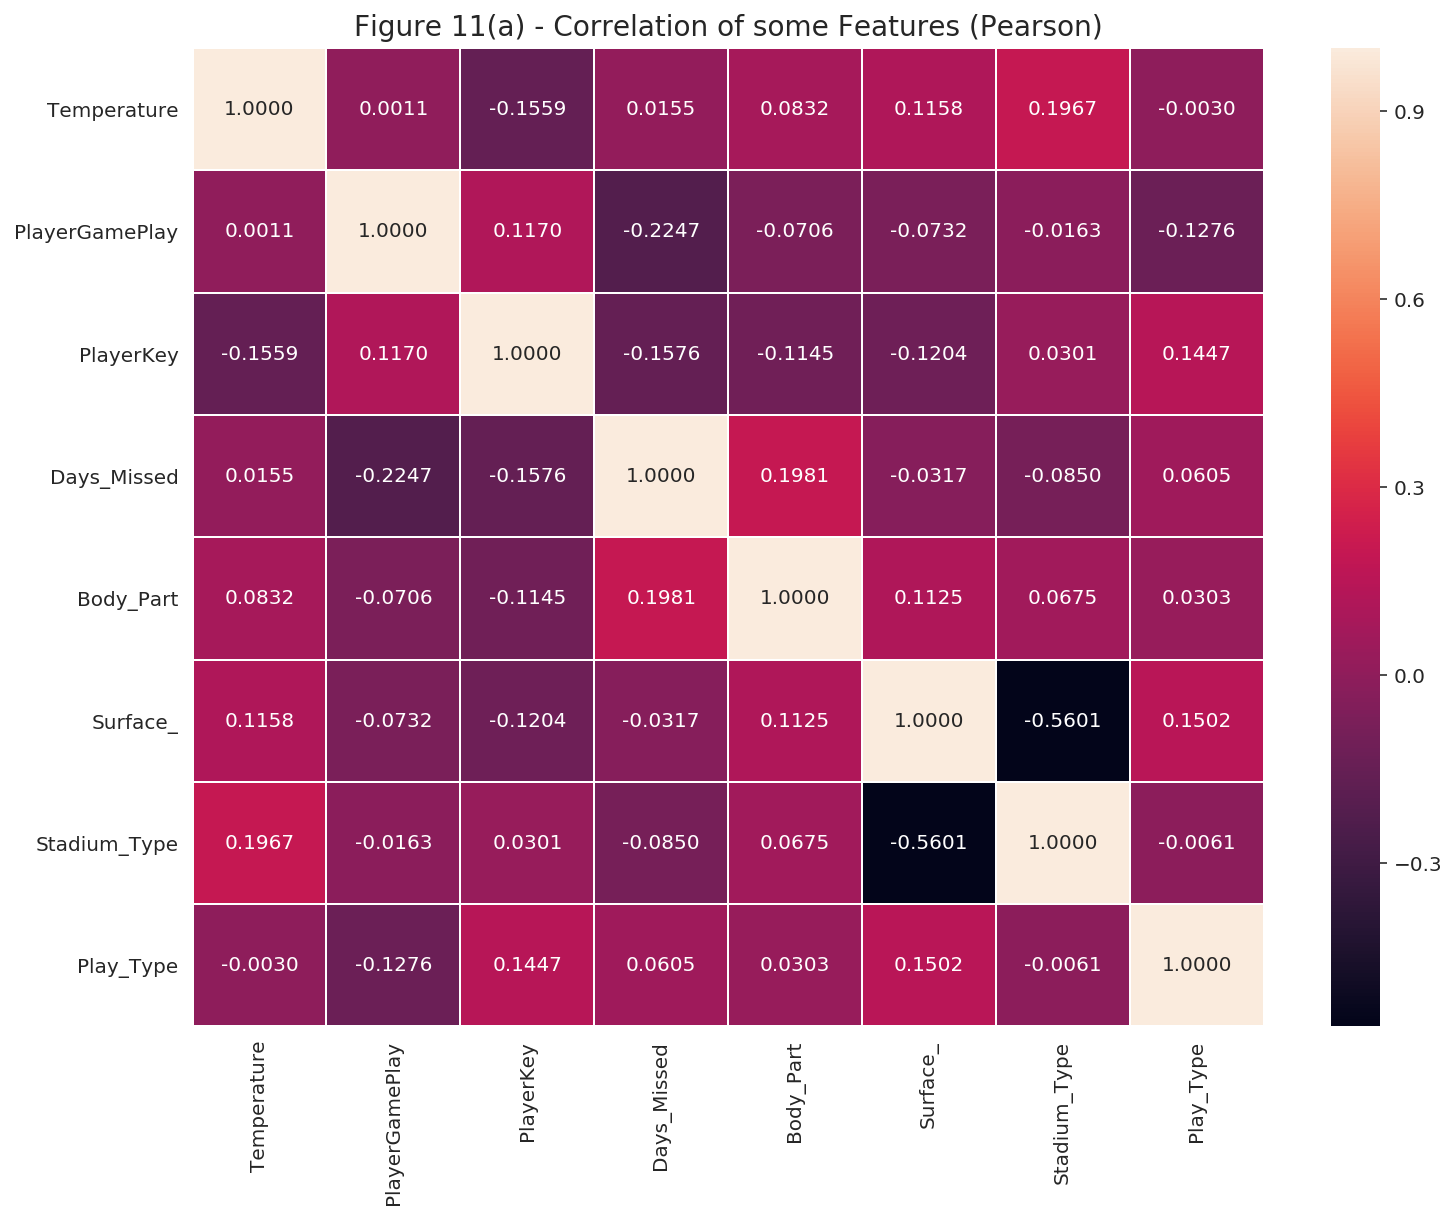

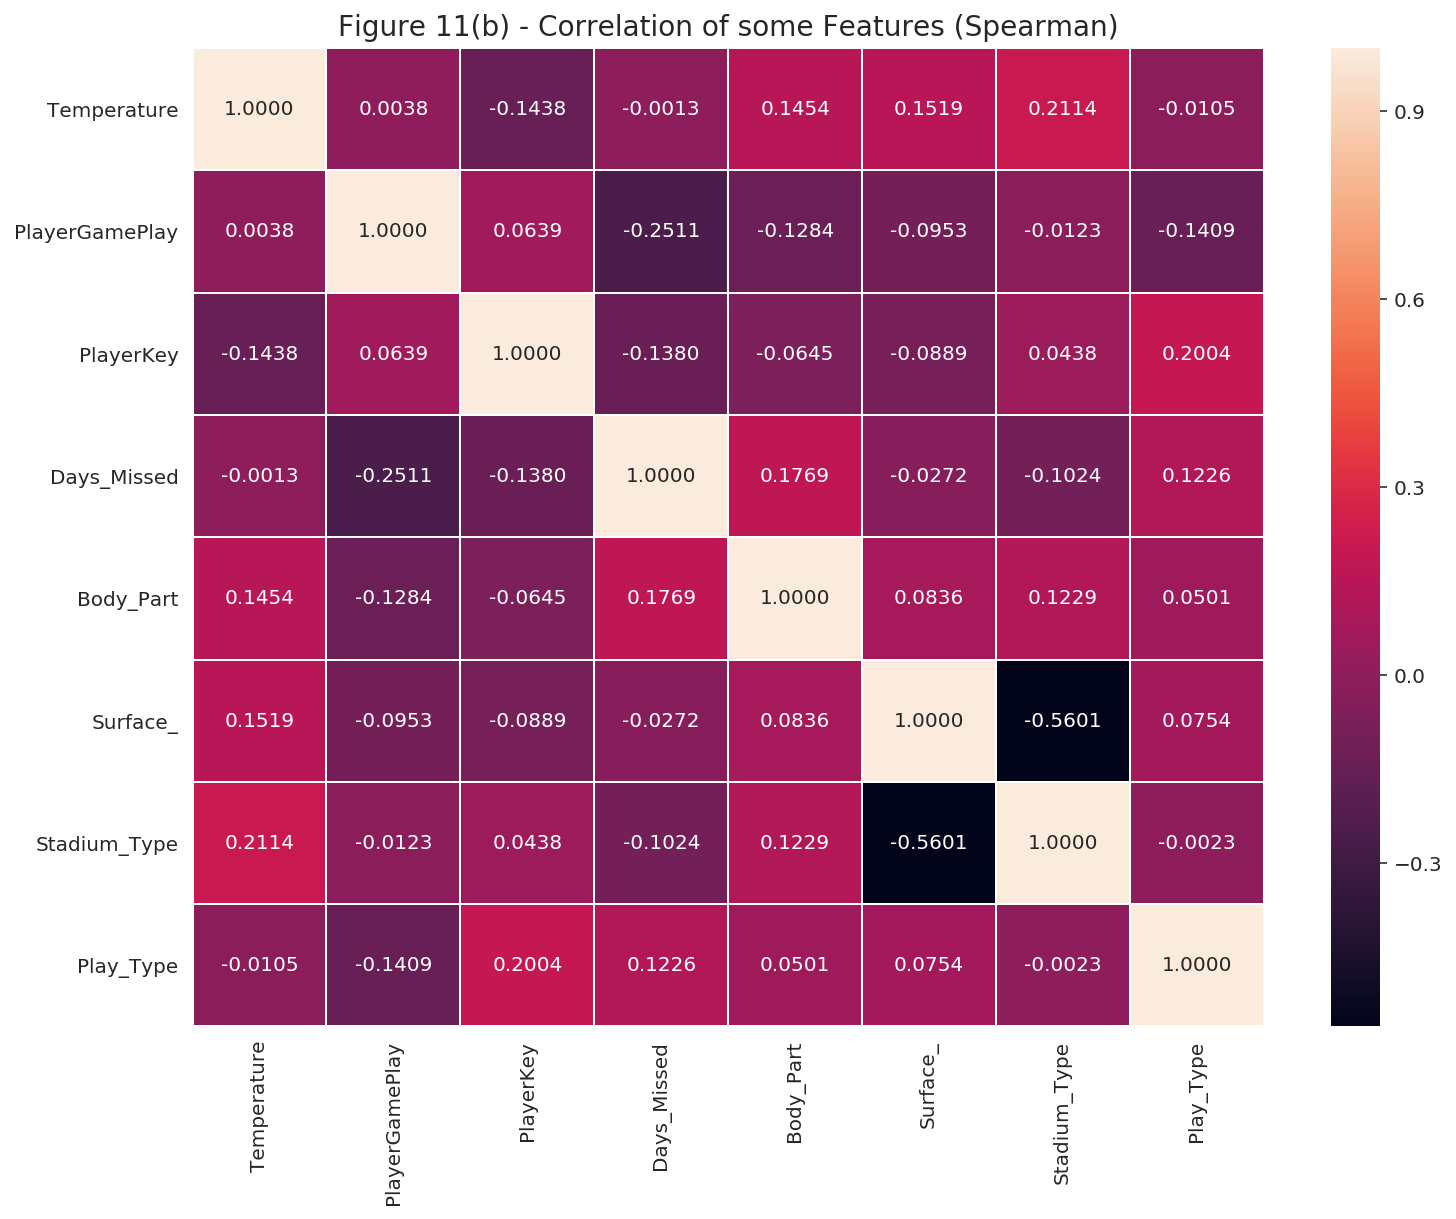

In [21]:
days_miss_dict = {"1+" : 1, "7+" : 2, "28+" : 3, "42+" : 4}

inj_playlist['Days_Missed'] = inj_playlist["DaysMissed"].map(days_miss_dict)
inj_playlist['Days_Missed'] = inj_playlist["Days_Missed"].astype(float)

body_part_dict = {"Ankle" : 0, "Knee" : 1, "Toes" : 2, "Foot" : 3, "Heel" : 4}

inj_playlist["Body_Part"] = inj_playlist["BodyPart"].map(body_part_dict)
inj_playlist["Body_Part"] = inj_playlist["Body_Part"].astype(float)

surface_dict = {"Synthetic" : 0, "Natural" : 1}

inj_playlist["Surface_"] = inj_playlist["Surface"].map(surface_dict)
inj_playlist["Surface_"] = inj_playlist["Surface_"].astype(float)


stadium_dict = {"Outdoor" : 0, "Indoor" : 1, "Bowl" : 2, "Heinz Field" : 3, "Outside" : 4}

inj_playlist["Stadium_Type"] = inj_playlist["StadiumType"].map(stadium_dict)
inj_playlist["Stadium_Type"] = inj_playlist["Stadium_Type"].astype(float)

playtype_dict = {'Pass' : 0,
 'Rush' : 1,
 'Kickoff' : 2,
 'Kickoff Not Returned' : 3,
 'Kickoff Returned' : 4,               
 'Field Goal' : 5,
 'Punt' : 6,
 'Punt Not Returned' : 7,
 'Punt Returned' : 8,
 'Extra Point' : 9}

inj_playlist["Play_Type"] = inj_playlist["PlayType"].map(playtype_dict)
inj_playlist["Play_Type"] = inj_playlist["Play_Type"].astype(float)

f,ax = plt.subplots(figsize=(12, 9))
sns.heatmap(inj_playlist.corr("pearson"), annot=True, linewidths=.5, fmt= '.4f',ax=ax)
plt.title("Figure 11(a) - Correlation of some Features (Pearson)", fontsize=14)
plt.show()

f,ax = plt.subplots(figsize=(12, 9))
sns.heatmap(inj_playlist.corr("spearman"), annot=True, linewidths=.5, fmt= '.4f',ax=ax)
plt.title("Figure 11(b) - Correlation of some Features (Spearman)", fontsize=14)
plt.show()

Analyzing the features correlation (Pearson and Spearman) with `BodyPart`, can be noted:
* None of the features have a high correlation (0.75 or more, negative or positive) with `BodyPart`.
* `BodyPart` has positive correlation with all features.

# 3.2 Exploring Player Track Data

Let's explore the `player_track` and see how the plays lead the player to an injury.<br>
Starting with the routes for injured players in synthetic field, as shown on Figure 12. See this nice [Kernel](https://www.kaggle.com/robikscube/nfl-1st-and-future-analytics-intro) where the field plot was developed.

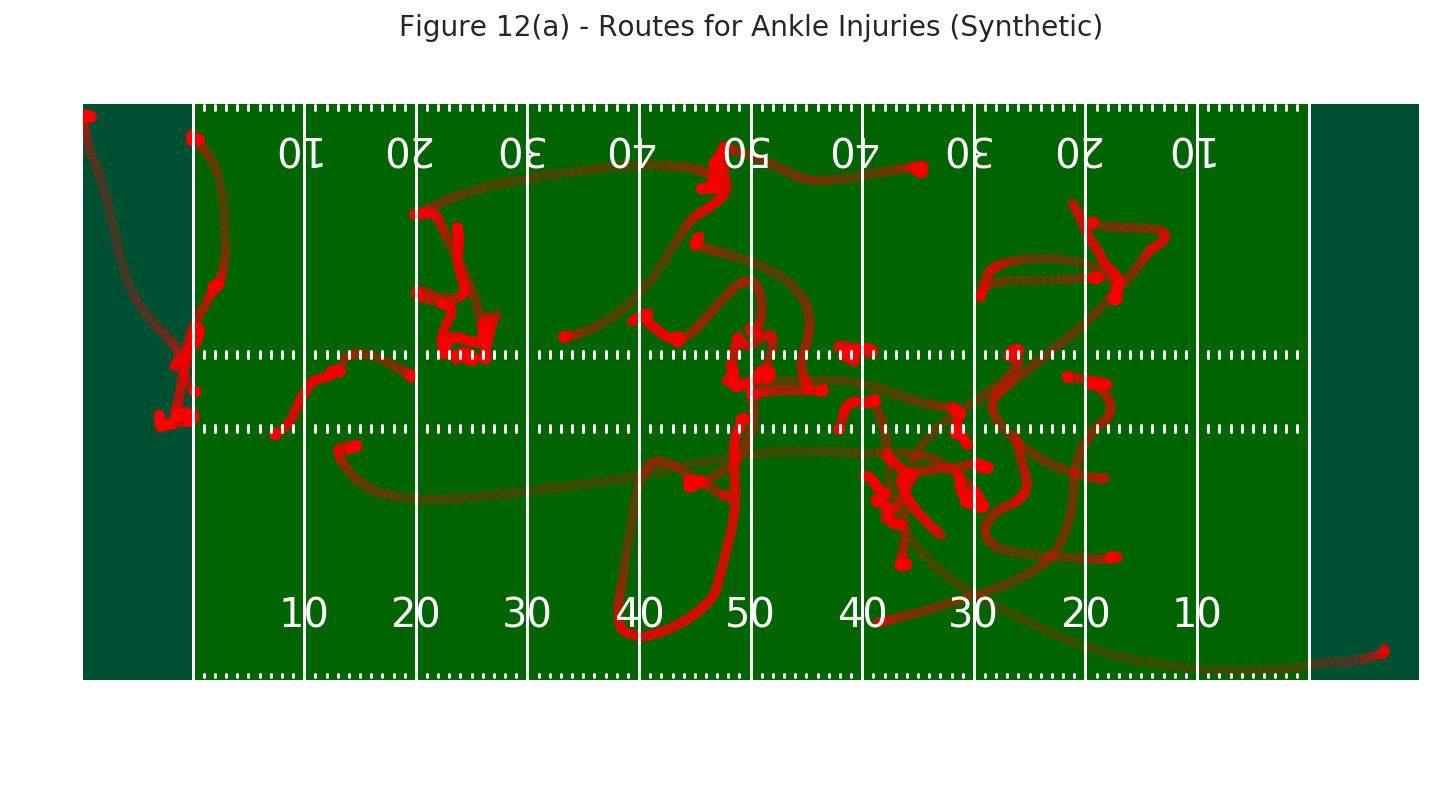

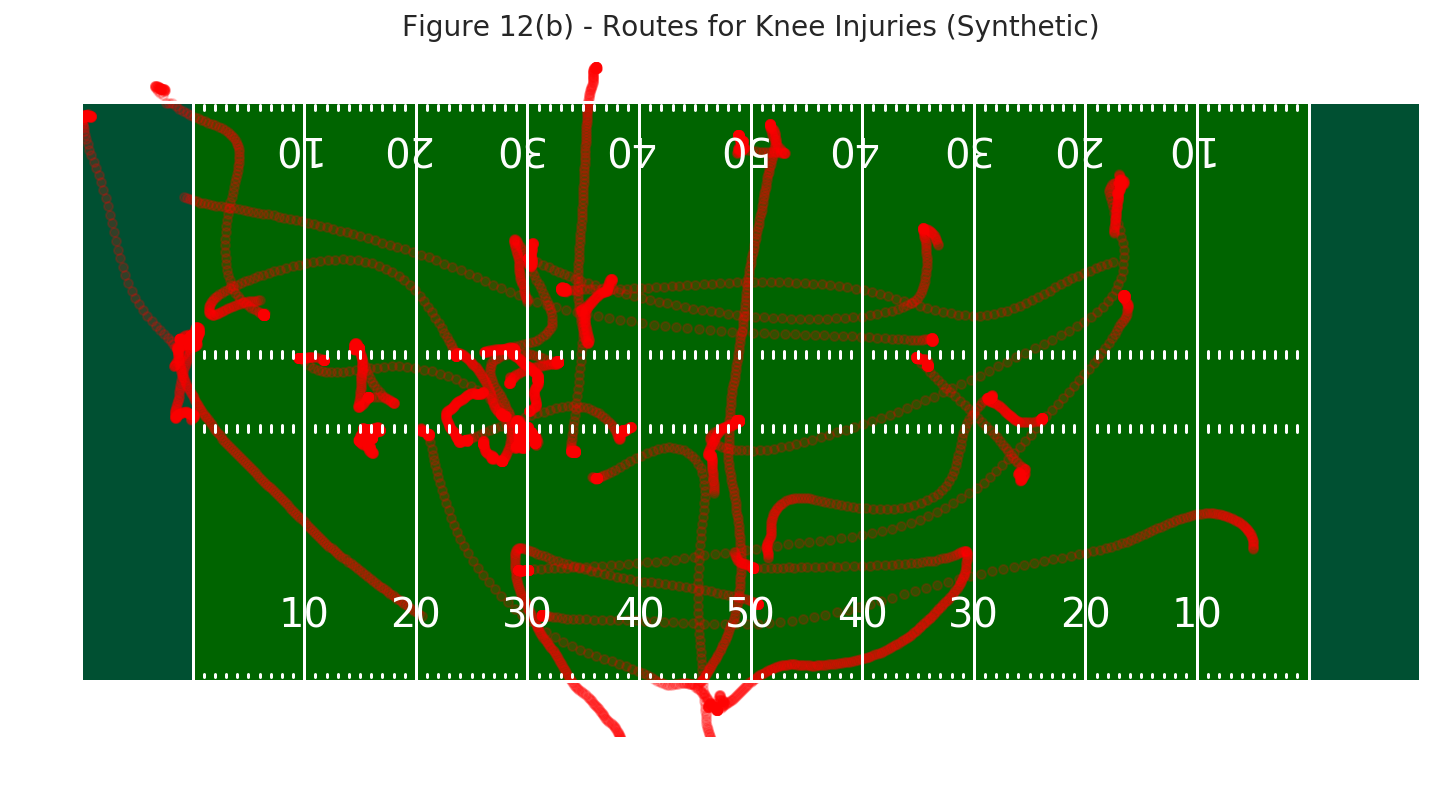

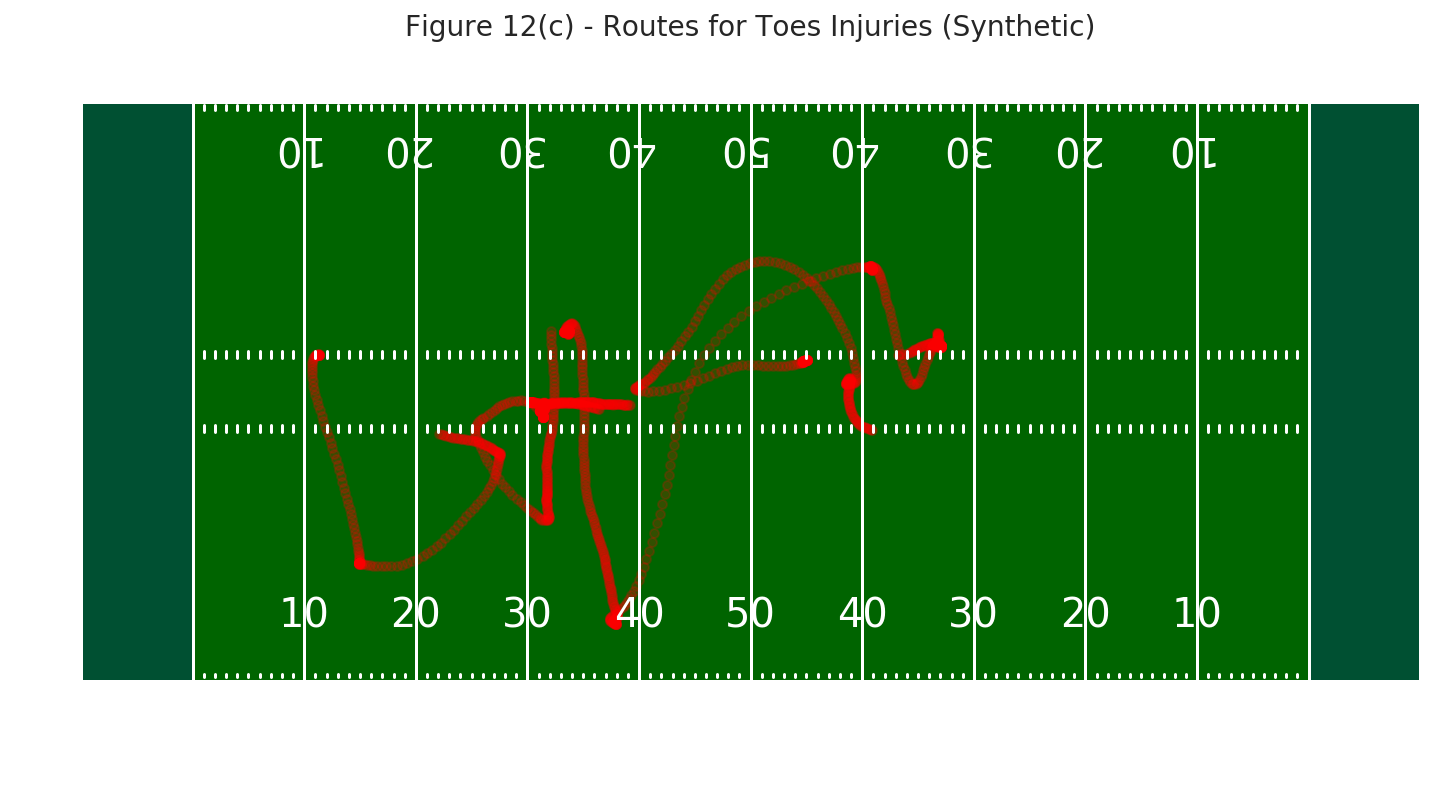

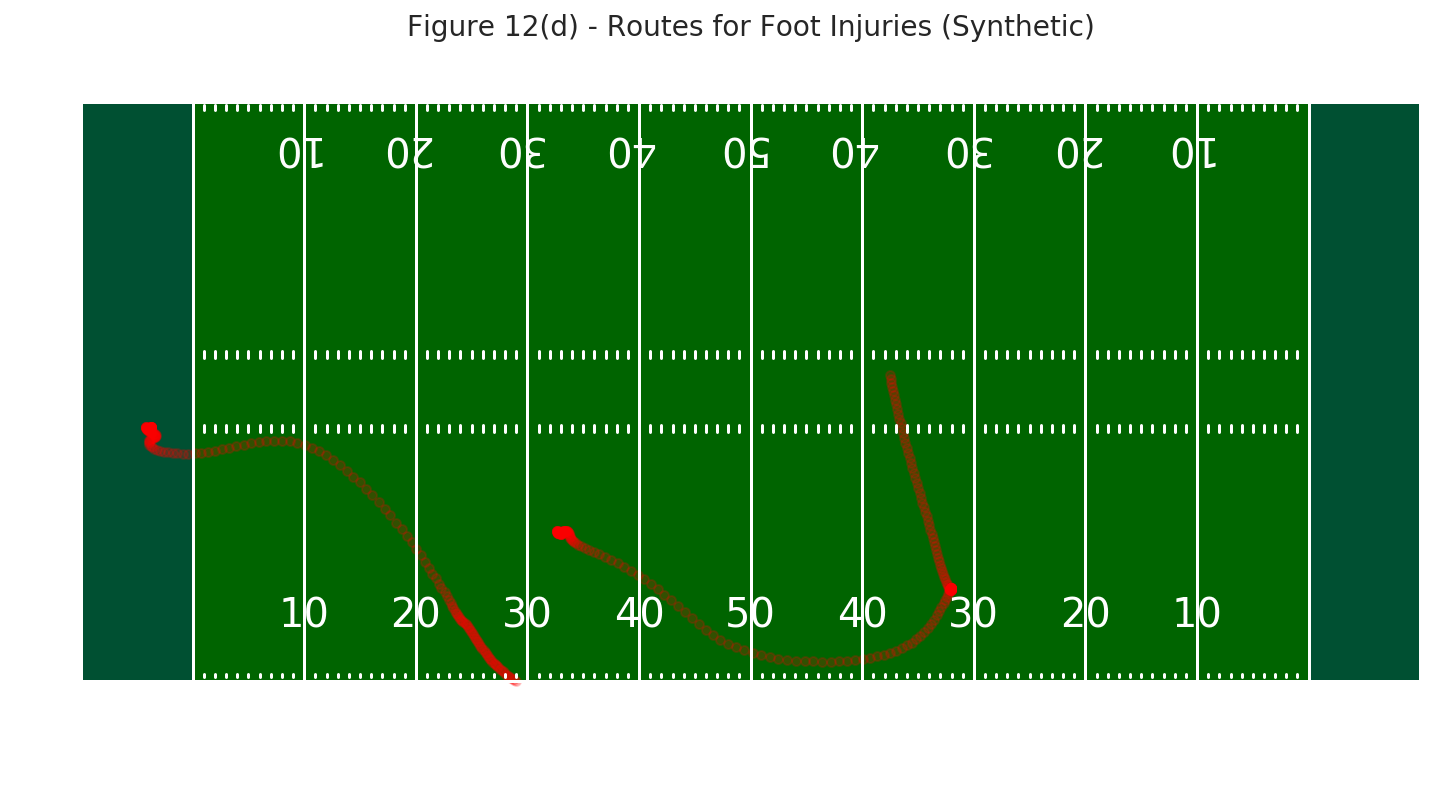

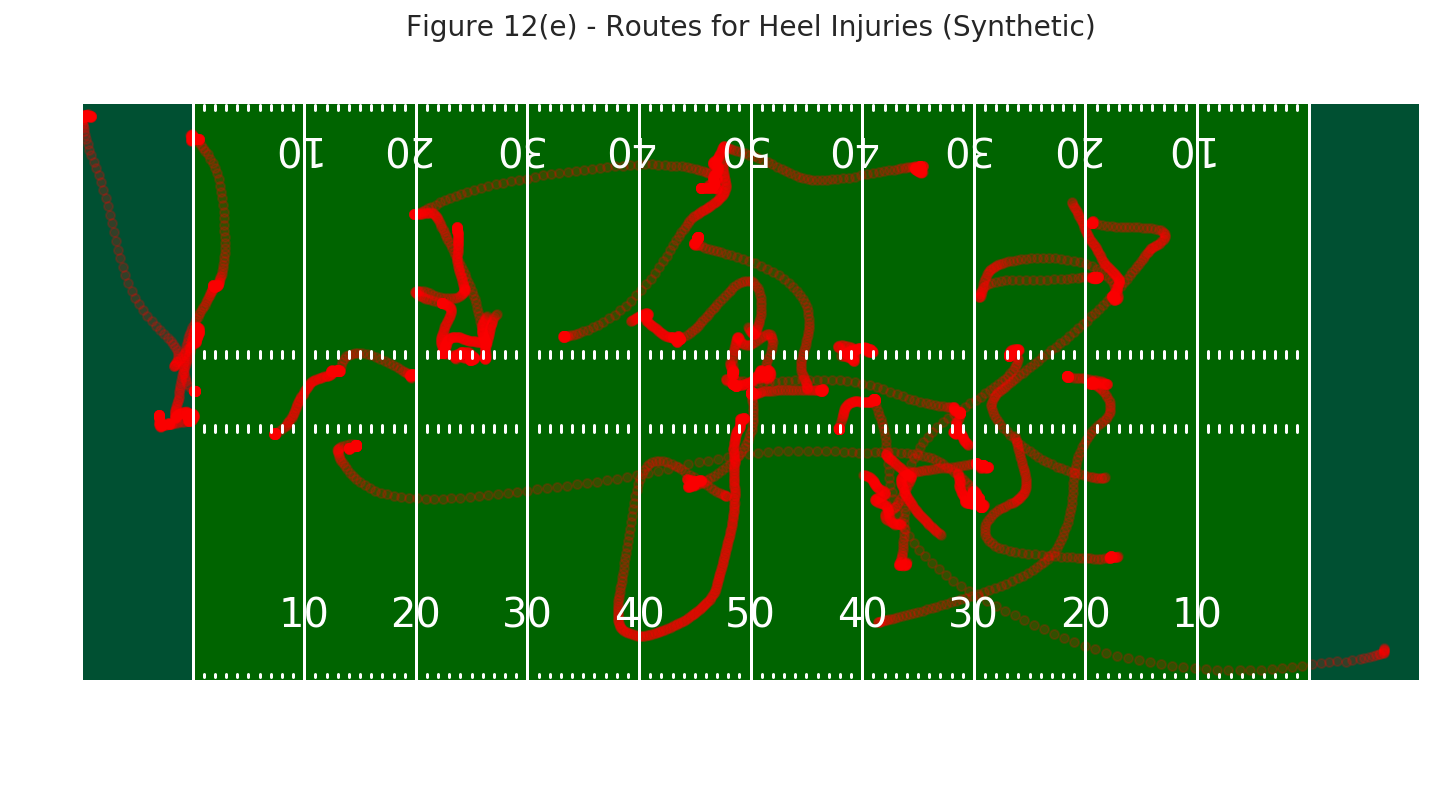

In [22]:
df_syn = inj_playlist[inj_playlist["Surface"] == "Synthetic"]
df_syn = df_syn[df_syn["BodyPart"] == "Ankle"]
df_syn_list = df_syn['PlayKey'].tolist()
fig, ax = create_football_field()
for playkey, inj_play in player_track.query('PlayKey in @df_syn_list').groupby('PlayKey'):
    inj_play.plot(kind='scatter', x='x', y='y', ax=ax, color='red', alpha=0.2)

plt.title("Figure 12(a) - Routes for Ankle Injuries (Synthetic)", fontsize=14)
plt.show()

df_syn = inj_playlist[inj_playlist["Surface"] == "Synthetic"]
df_syn = df_syn[df_syn["BodyPart"] == "Knee"]
df_syn_list = df_syn['PlayKey'].tolist()
fig, ax = create_football_field()
for playkey, inj_play in player_track.query('PlayKey in @df_syn_list').groupby('PlayKey'):
    inj_play.plot(kind='scatter', x='x', y='y', ax=ax, color='red', alpha=0.2)

plt.title("Figure 12(b) - Routes for Knee Injuries (Synthetic)", fontsize=14)
plt.show()

df_syn = inj_playlist[inj_playlist["Surface"] == "Synthetic"]
df_syn = df_syn[df_syn["BodyPart"] == "Toes"]
df_syn_list = df_syn['PlayKey'].tolist()
fig, ax = create_football_field()
for playkey, inj_play in player_track.query('PlayKey in @df_syn_list').groupby('PlayKey'):
    inj_play.plot(kind='scatter', x='x', y='y', ax=ax, color='red', alpha=0.2)

plt.title("Figure 12(c) - Routes for Toes Injuries (Synthetic)", fontsize=14)
plt.show()

df_syn = inj_playlist[inj_playlist["Surface"] == "Synthetic"]
df_syn = df_syn[df_syn["BodyPart"] == "Foot"]
df_syn_list = df_syn['PlayKey'].tolist()
fig, ax = create_football_field()
for playkey, inj_play in player_track.query('PlayKey in @df_syn_list').groupby('PlayKey'):
    inj_play.plot(kind='scatter', x='x', y='y', ax=ax, color='red', alpha=0.2)

plt.title("Figure 12(d) - Routes for Foot Injuries (Synthetic)", fontsize=14)
plt.show()

df_syn = inj_playlist[inj_playlist["Surface"] == "Synthetic"]
df_syn = df_syn[df_syn["BodyPart"] == "Ankle"]
df_syn_list = df_syn['PlayKey'].tolist()
fig, ax = create_football_field()
for playkey, inj_play in player_track.query('PlayKey in @df_syn_list').groupby('PlayKey'):
    inj_play.plot(kind='scatter', x='x', y='y', ax=ax, color='red', alpha=0.2)

plt.title("Figure 12(e) - Routes for Heel Injuries (Synthetic)", fontsize=14)
plt.show()

On Figure 12 we can note:
* Ankle, Knee and Heel injuries there are no visible pattern.
* There some routes outside the field for knee injuries.
* Toes Injuries are near from the traced lines of the field center.
* Foot Injuries are outside from the traced lines of the field center.

And now on Natural Surface, as shown on Figure 13.

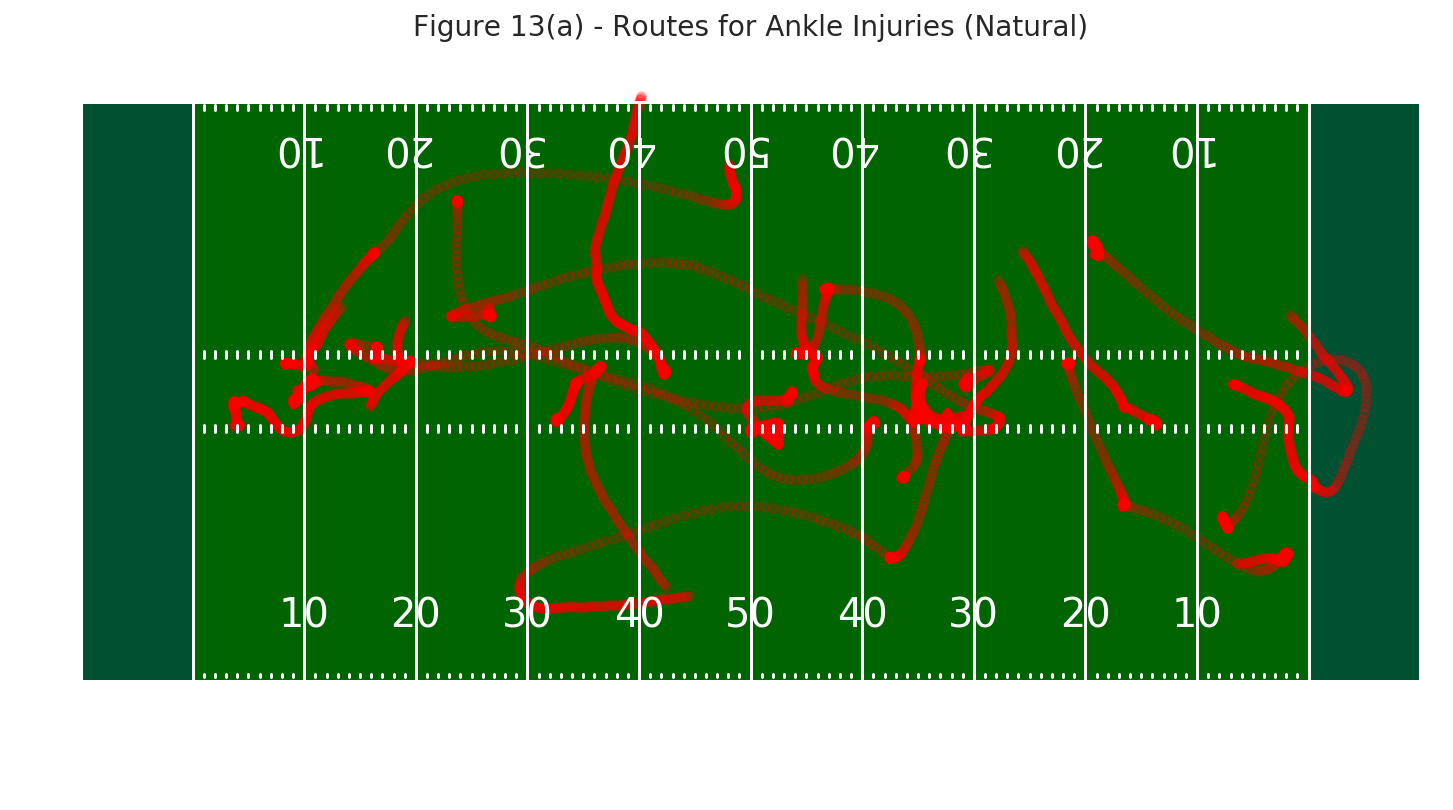

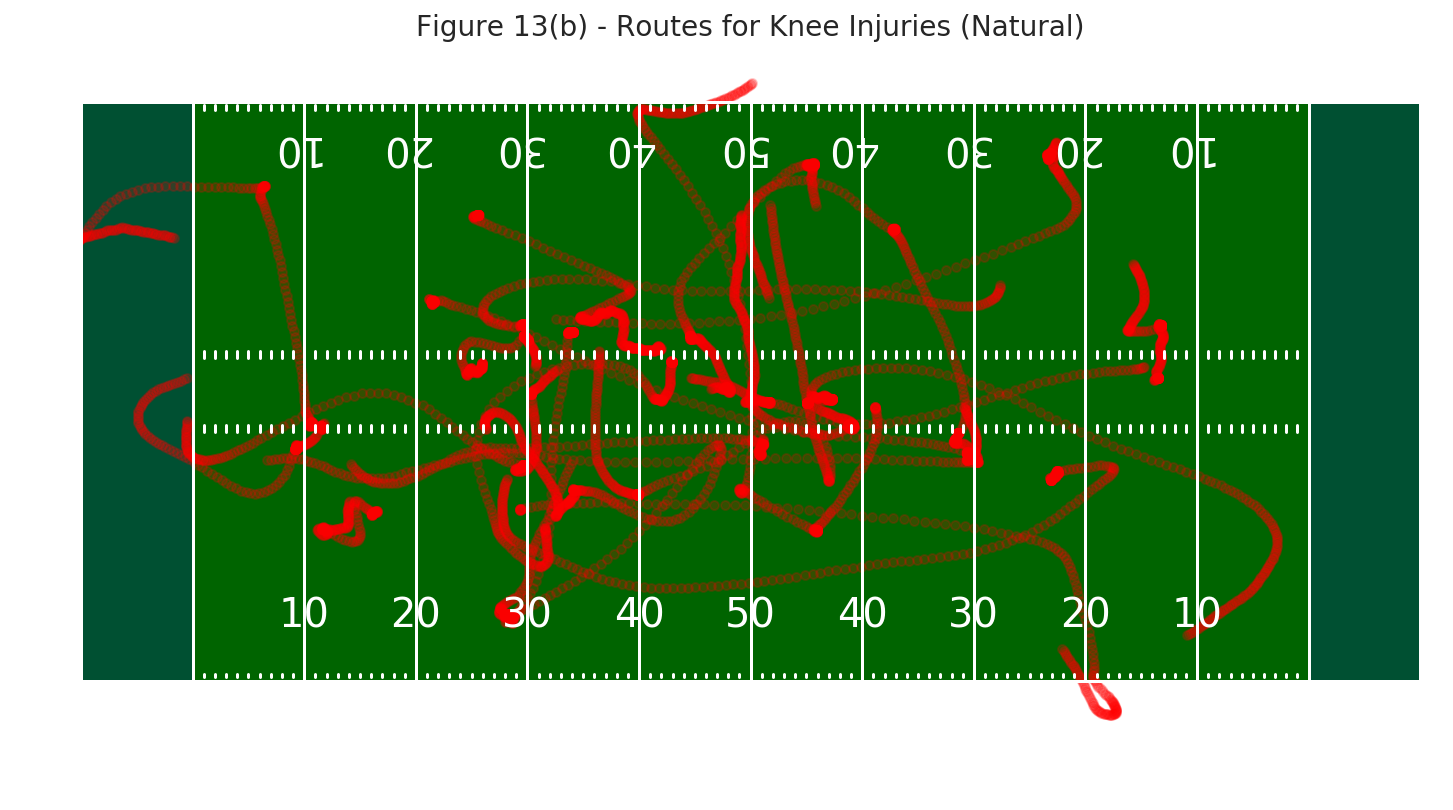

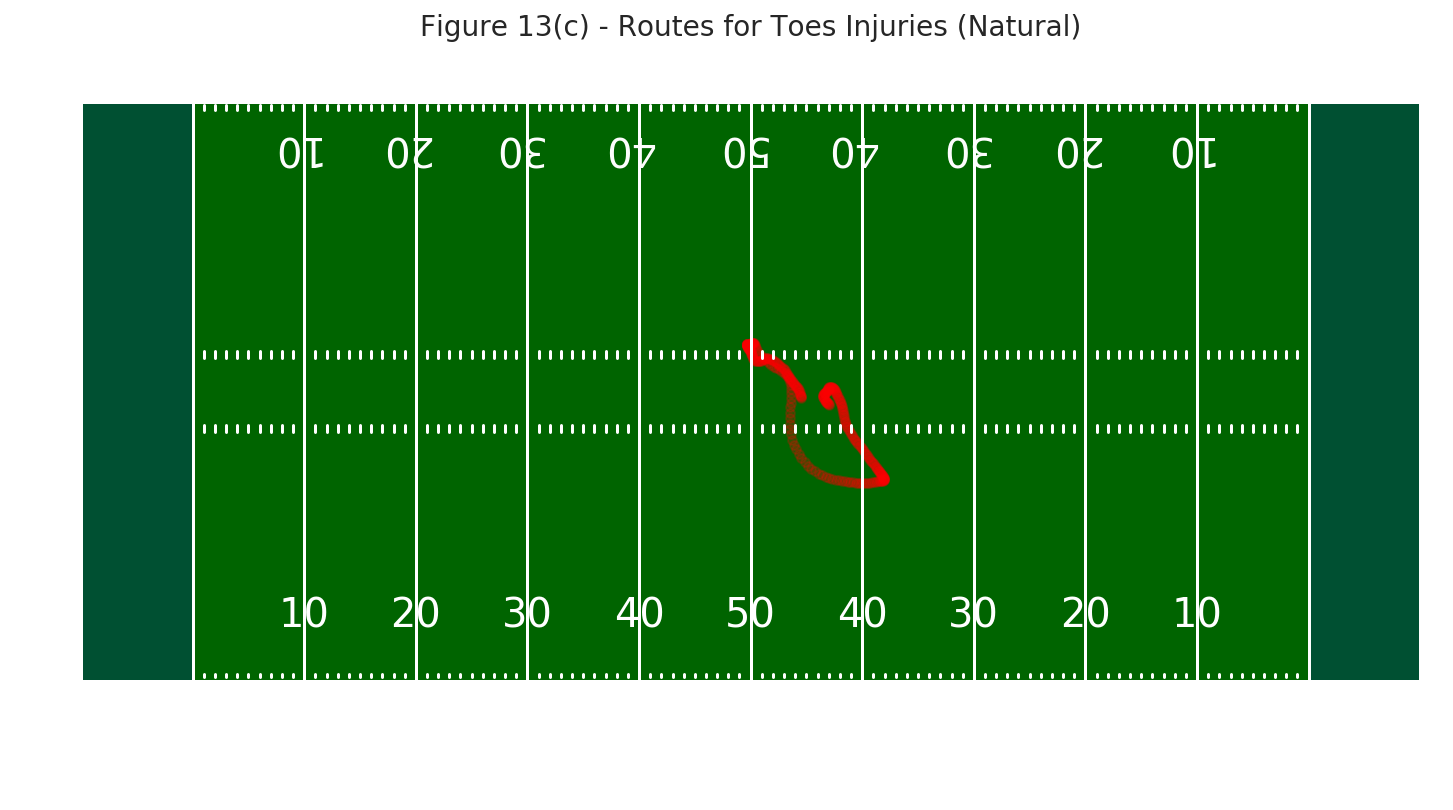

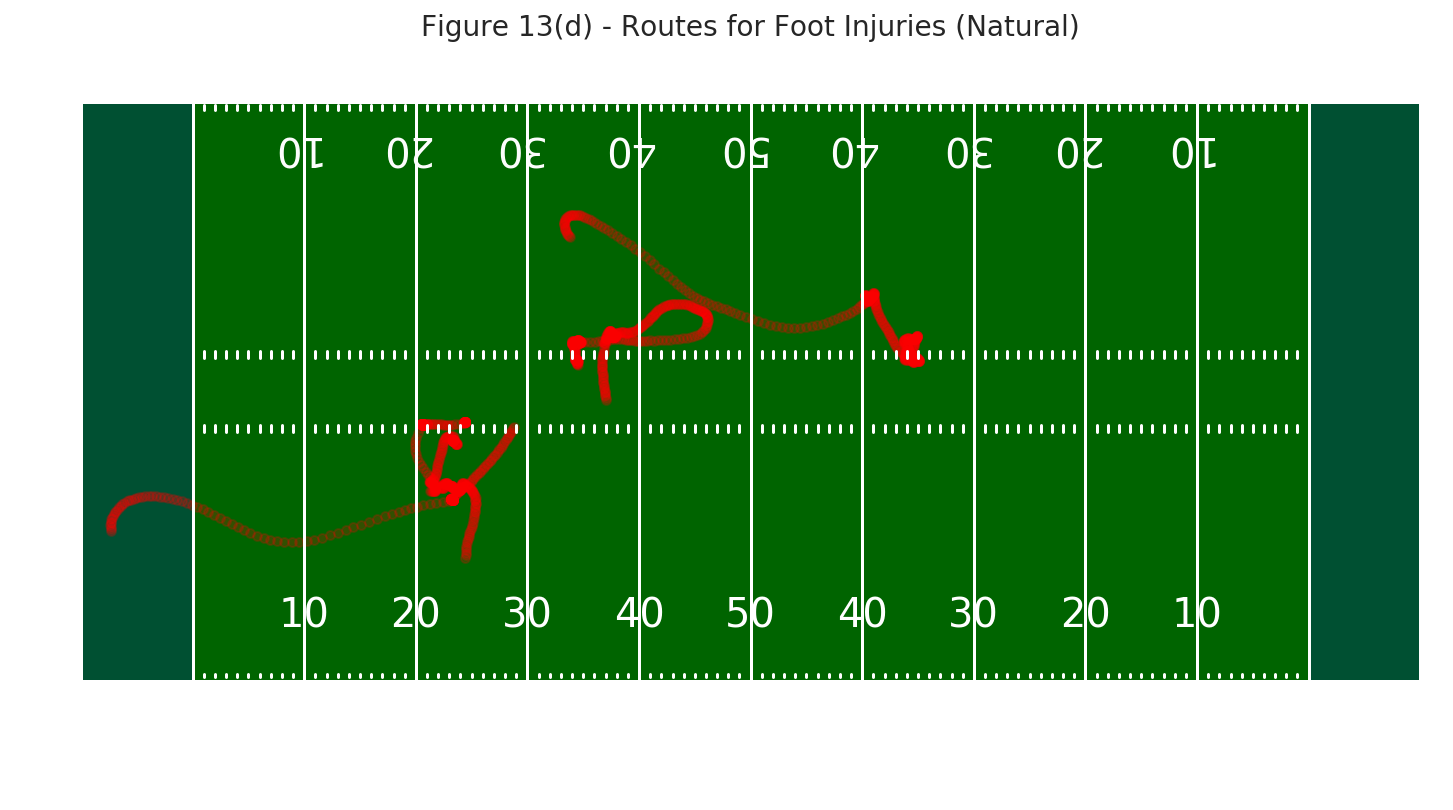

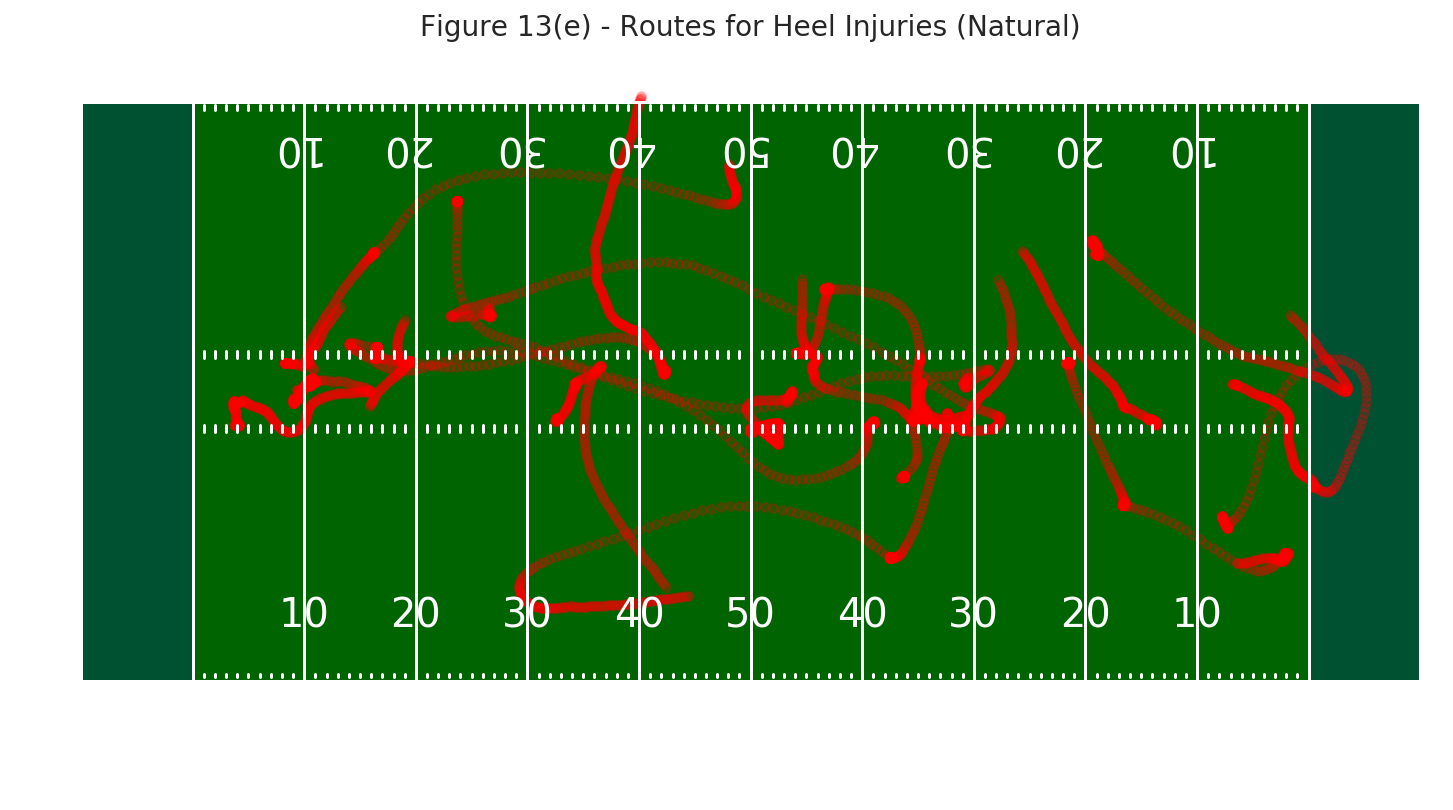

In [23]:
df_syn = inj_playlist[inj_playlist["Surface"] == "Natural"]
df_syn = df_syn[df_syn["BodyPart"] == "Ankle"]
df_syn_list = df_syn['PlayKey'].tolist()
fig, ax = create_football_field()
for playkey, inj_play in player_track.query('PlayKey in @df_syn_list').groupby('PlayKey'):
    inj_play.plot(kind='scatter', x='x', y='y', ax=ax, color='red', alpha=0.2)

plt.title("Figure 13(a) - Routes for Ankle Injuries (Natural)", fontsize=14)
plt.show()

df_syn = inj_playlist[inj_playlist["Surface"] == "Natural"]
df_syn = df_syn[df_syn["BodyPart"] == "Knee"]
df_syn_list = df_syn['PlayKey'].tolist()
fig, ax = create_football_field()
for playkey, inj_play in player_track.query('PlayKey in @df_syn_list').groupby('PlayKey'):
    inj_play.plot(kind='scatter', x='x', y='y', ax=ax, color='red', alpha=0.2)

plt.title("Figure 13(b) - Routes for Knee Injuries (Natural)", fontsize=14)
plt.show()

df_syn = inj_playlist[inj_playlist["Surface"] == "Natural"]
df_syn = df_syn[df_syn["BodyPart"] == "Toes"]
df_syn_list = df_syn['PlayKey'].tolist()
fig, ax = create_football_field()
for playkey, inj_play in player_track.query('PlayKey in @df_syn_list').groupby('PlayKey'):
    inj_play.plot(kind='scatter', x='x', y='y', ax=ax, color='red', alpha=0.2)

plt.title("Figure 13(c) - Routes for Toes Injuries (Natural)", fontsize=14)
plt.show()

df_syn = inj_playlist[inj_playlist["Surface"] == "Natural"]
df_syn = df_syn[df_syn["BodyPart"] == "Foot"]
df_syn_list = df_syn['PlayKey'].tolist()
fig, ax = create_football_field()
for playkey, inj_play in player_track.query('PlayKey in @df_syn_list').groupby('PlayKey'):
    inj_play.plot(kind='scatter', x='x', y='y', ax=ax, color='red', alpha=0.2)

plt.title("Figure 13(d) - Routes for Foot Injuries (Natural)", fontsize=14)
plt.show()

df_syn = inj_playlist[inj_playlist["Surface"] == "Natural"]
df_syn = df_syn[df_syn["BodyPart"] == "Ankle"]
df_syn_list = df_syn['PlayKey'].tolist()
fig, ax = create_football_field()
for playkey, inj_play in player_track.query('PlayKey in @df_syn_list').groupby('PlayKey'):
    inj_play.plot(kind='scatter', x='x', y='y', ax=ax, color='red', alpha=0.2)

plt.title("Figure 13(e) - Routes for Heel Injuries (Natural)", fontsize=14)
plt.show()

On the Figure 13 we can note:
* Ankle, Knee and Heel injuries there are no visible pattern.
* There are concentrated knee injuries on the traced lines of the field center.
* Toes Injuries are inside from the traced lines of the field center.
* Foot Injuries are outside from the traced lines of the field center, with some part of the route on the traced lines on the field center.

In [24]:
df_data = {"delta_time": [0.0], "delta_x": [0.0], "delta_y": [0.0], 
                               "delta_dir": [0.0], "delta_dis": [0.0], "delta_o": [0.0], "delta_s": [0.0]}


df_aux_c = pd.DataFrame(columns=["delta_time", "delta_x", "delta_y", "delta_dir", "delta_dis", "delta_o", "delta_s"])
df_aux = pd.DataFrame(data=df_data)
df_aux_b = inj_playlist[inj_playlist.BodyPart.notnull()]
for i in range(len(inj_playlist[inj_playlist.BodyPart.notnull()])):
    aux = df_aux_b["PlayKey"].values[i]
    aux = player_track[player_track["PlayKey"] == aux]
    aux_a = aux.head(1)
    aux_b = aux.tail(1)
    df_aux_c[["delta_time", "delta_x", "delta_y", "delta_dir", "delta_dis", "delta_o", "delta_s"]] = aux_b[["time",
                                                                                                          "x", "y", "dir", "dis", 
                                                              "o", "s"]] - aux_a[["time", "x", "y", "dir", "dis", "o", "s"]].values
    df_aux = df_aux.append(df_aux_c)
    df_aux_c.reset_index(drop=True, inplace=True)
    df_aux_c = df_aux_c.drop(df_aux_c.index[0])
    df_aux.reset_index(drop=True, inplace=True)
df_aux = df_aux.drop(df_aux.index[0])

In [25]:
inj_track = pd.concat([injury_record, df_aux], axis=1)

For the other features on `player_track` (`time`, `x`, `y`, `dir`, `dis`, `o`, `s`), let's calculate the difference between the feature value at the end of the play and the start of the play, and call it "Delta". <br>
I will not use absolute values, because is worth to see any change for negative values, like orientatation changes. <br>
Starting with Delta Time, on the Figure 14. This feature cannot get negative values.

In [26]:
fig = make_subplots(rows=1, cols=5, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"},
                                          {"type": "xy"}, {"type": "xy"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Ankle', 
                                      '(b) Knee',
                                      '(c) Toes',
                                      '(d) Foot',
                                      '(e) Heel'))

feature_filter = "BodyPart"
feature_value = ["Ankle", "Knee", "Toes", "Foot", "Heel"]
col_num = 1

for i in feature_value:
    df_aux = inj_track[inj_track[feature_filter] == i]
    value = df_aux.delta_time.values
    fig.add_trace(go.Histogram(x=value, showlegend=False),
                 row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, width=800, title="Figure 14 - Injuries by Delta Time", title_x=0.5)
fig.show()

We can see that most Ankle and Knee injuries occur before 40s, while all toe injuries occur before 40s. Foot injuries occur most times between 20s and 30s. The documented Heel injury occured around 30s.<br>
Let's check Delta X on the Figure 15.

In [27]:
fig = make_subplots(rows=1, cols=5, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"},
                                          {"type": "xy"}, {"type": "xy"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Ankle', 
                                      '(b) Knee',
                                      '(c) Toes',
                                      '(d) Foot',
                                      '(e) Heel'))

feature_filter = "BodyPart"
feature_value = ["Ankle", "Knee", "Toes", "Foot", "Heel"]
col_num = 1

for i in feature_value:
    df_aux = inj_track[inj_track[feature_filter] == i]
    value = df_aux.delta_x.values
    fig.add_trace(go.Histogram(x=value, showlegend=False),
                 row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, width=800, title="Figure 15 - Injuries by Delta X", title_x=0.5)
fig.show()

Notable things here:
* Most Ankle injuries occur when Delta X goes negative.
* Most Knee injuries occur with Delta X around zero, almost no movement at x coordinate of the field.
<br>
<br>
Let's see Delta Y on the Figure 16.

In [28]:
fig = make_subplots(rows=1, cols=5, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"},
                                          {"type": "xy"}, {"type": "xy"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Ankle', 
                                      '(b) Knee',
                                      '(c) Toes',
                                      '(d) Foot',
                                      '(e) Heel'))

feature_filter = "BodyPart"
feature_value = ["Ankle", "Knee", "Toes", "Foot", "Heel"]
col_num = 1

for i in feature_value:
    df_aux = inj_track[inj_track[feature_filter] == i]
    value = df_aux.delta_y.values
    fig.add_trace(go.Histogram(x=value, showlegend=False),
                 row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, width=800, title="Figure 16 - Injuries by Delta Y", title_x=0.5)
fig.show()

While Delta X goes negative most times for Ankle injuries, Delta Y goes positive.<br>
Knee injuries have some outliers with negative values near -40. Most Toes injuries are negative.<br>
Time to explore Delta Direction on the Figure 17.

In [29]:
fig = make_subplots(rows=1, cols=5, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"},
                                          {"type": "xy"}, {"type": "xy"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Ankle', 
                                      '(b) Knee',
                                      '(c) Toes',
                                      '(d) Foot',
                                      '(e) Heel'))

feature_filter = "BodyPart"
feature_value = ["Ankle", "Knee", "Toes", "Foot", "Heel"]
col_num = 1

for i in feature_value:
    df_aux = inj_track[inj_track[feature_filter] == i]
    value = df_aux.delta_dir.values
    fig.add_trace(go.Histogram(x=value, showlegend=False),
                 row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, width=800, title="Figure 17 - Injuries by Delta Direction", title_x=0.5)
fig.show()

There's no much changes in direction for Ankle and Knee injuries, most values are around 0. In toes, most injuries occur between 0 and 100. <br>
Let's the Delta distance on the Figure 18.


In [30]:
fig = make_subplots(rows=1, cols=5, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"},
                                          {"type": "xy"}, {"type": "xy"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Ankle', 
                                      '(b) Knee',
                                      '(c) Toes',
                                      '(d) Foot',
                                      '(e) Heel'))

feature_filter = "BodyPart"
feature_value = ["Ankle", "Knee", "Toes", "Foot", "Heel"]
col_num = 1

for i in feature_value:
    df_aux = inj_track[inj_track[feature_filter] == i]
    value = df_aux.delta_dis.values
    fig.add_trace(go.Histogram(x=value, showlegend=False),
                 row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, width=800, title="Figure 18 - Injuries by Delta Distance", title_x=0.5)
fig.show()

Interest to note in the Figure 18 that most injuries not occur by changes in distance, and sometimes the value is negative, maybe the player got a super tackle? We can see that only for heel injury the player got 1 yard in the delta.<br>
Let's explore the Delta Orientation on the Figure 19.

In [31]:
fig = make_subplots(rows=1, cols=5, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"},
                                          {"type": "xy"}, {"type": "xy"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Ankle', 
                                      '(b) Knee',
                                      '(c) Toes',
                                      '(d) Foot',
                                      '(e) Heel'))

feature_filter = "BodyPart"
feature_value = ["Ankle", "Knee", "Toes", "Foot", "Heel"]
col_num = 1

for i in feature_value:
    df_aux = inj_track[inj_track[feature_filter] == i]
    value = df_aux.delta_o.values
    fig.add_trace(go.Histogram(x=value, showlegend=False),
                 row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, width=800, title="Figure 19 - Injuries by Delta Orientation", title_x=0.5)
fig.show()

On the orientation, most injuries occur with no changes, but on heel there's a change between -179 and -178 degrees.

And finally, explore Delta speed on the Figure 20.

In [32]:
fig = make_subplots(rows=1, cols=5, specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"},
                                          {"type": "xy"}, {"type": "xy"}]], 
                    shared_xaxes=True, shared_yaxes=True,
                    vertical_spacing=1,
                    subplot_titles = ('(a) Ankle', 
                                      '(b) Knee',
                                      '(c) Toes',
                                      '(d) Foot',
                                      '(e) Heel'))

feature_filter = "BodyPart"
feature_value = ["Ankle", "Knee", "Toes", "Foot", "Heel"]
col_num = 1

for i in feature_value:
    df_aux = inj_track[inj_track[feature_filter] == i]
    value = df_aux.delta_s.values
    fig.add_trace(go.Histogram(x=value, showlegend=False),
                 row=1, col=col_num)
    col_num = col_num+1

fig.update_layout(height=500, width=800, title="Figure 20 - Injuries by Delta Speed", title_x=0.5)
fig.show()

For all injuries, the most values are around 0 speed (No movement), with some peaks between 2 and 4 yards/s for knee, foot and toes injuries.<br>
Let's see the correlation of the Delta Features with the injured body part on Figure 21.


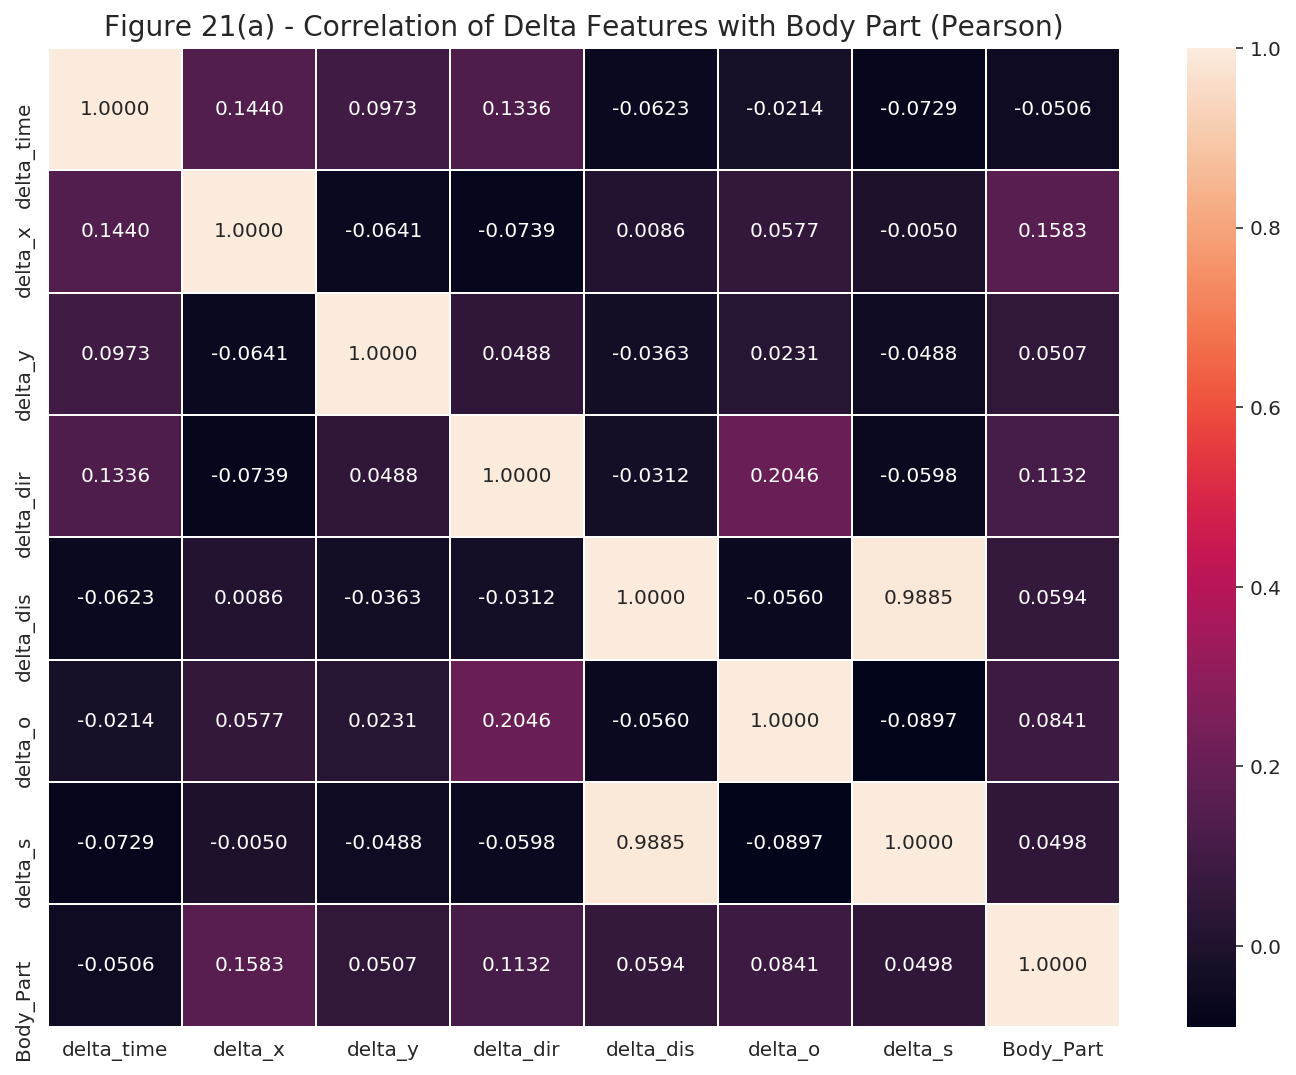

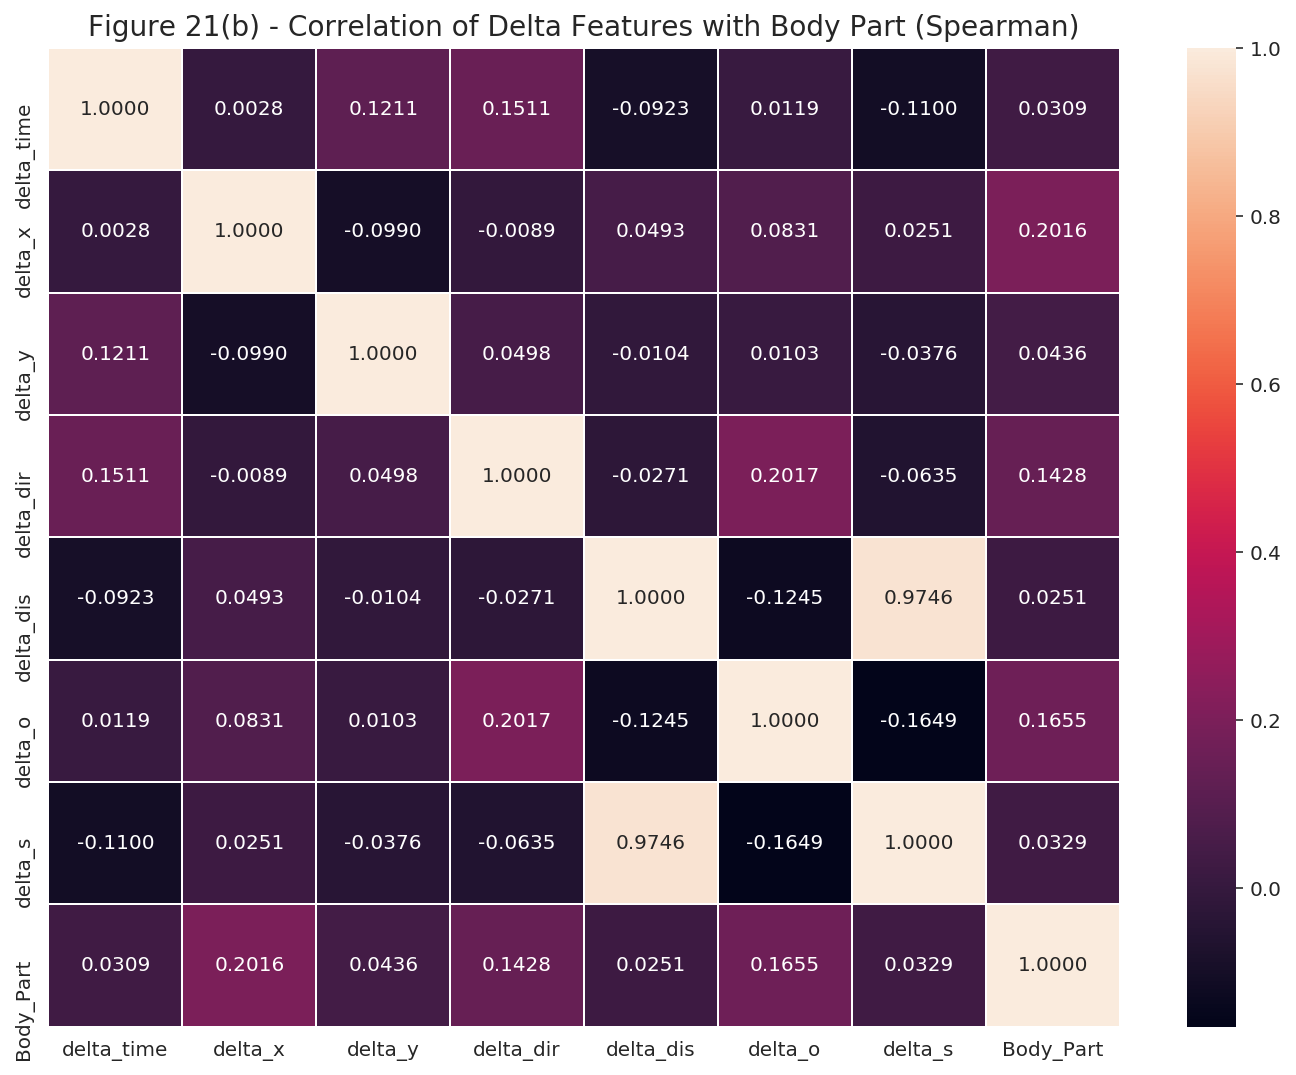

In [33]:
inj_track = inj_track.drop(columns=['PlayerKey'])

inj_track["Body_Part"] = inj_track["BodyPart"].map(body_part_dict)
inj_track["Body_Part"] = inj_track["Body_Part"].astype(float)

f,ax = plt.subplots(figsize=(12, 9))
sns.heatmap(inj_track.corr("pearson"), annot=True, linewidths=.5, fmt= '.4f',ax=ax)
plt.title("Figure 21(a) - Correlation of Delta Features with Body Part (Pearson)", fontsize=14)
plt.show()

f,ax = plt.subplots(figsize=(12, 9))
sns.heatmap(inj_track.corr("spearman"), annot=True, linewidths=.5, fmt= '.4f',ax=ax)
plt.title("Figure 21(b) - Correlation of Delta Features with Body Part (Spearman)", fontsize=14)
plt.show()

On Spearman's Rank coefficient can be noted that all Delta Features have positive correlation with the injured body part, but on the Pearson coefficient, there's a difference on the correlation between Delta Time and the Body Part, is negative here,confirming the information obtained in the Figure 14, where as shown with more time in a play, more chances to get a heel injury, and explain why at certain moments the Ankle and Knee injuries are present in the increased time of the play and decrease when have high values.

# 4. Conclusion

On this work, the data about injuries on football was explored and explained. <br>
We can draw the following conclusions:
* Ankle and Knee injuries are the most commons.
* Heel injury is the most rare.
* Most injuries occur in Synthetic Surfaces.
* A player is out of season, due injuries, most times between 1 and 7 days, or in long 42 or more days.
* Pass is the Play Type with most injuries.
* Linebackers and Wide Receivers have most injury risk.
* Most injuries occur in cloudy weather.
* Most injuries occur in Outdoor stadiums.
* High Temperatures contribute for injuries.
* Toes injuries occur most times in the center of the field, for both surfaces.
* Plays with high time value tend to cause more heel injuries, but remember that a heel injury is rare to confirming it with the available data.
* Players that got injured are stopped in few yards of distance. 

In this finish my work here! <br>
Feel free to give your feedback, I will appreciate it.<br>
<br>
Thanks for your reading!

![](https://media.giphy.com/media/jwKpxz0uGrqcTjDKvs/giphy.gif)